In [1]:
%matplotlib inline
import os
os.environ['PY3_PROD'] = '1'
%load_ext autoreload
%autoreload 2
os.system('kinit')

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import copy
import numpy as np
import math
import matplotlib as mpl
import matplotlib.dates as dates
import matplotlib.pyplot as plt
import datetime
import itertools
import pandas as pd

from pycmqlib3.utility import dbaccess, dataseries, misc
import pycmqlib3.analytics.data_handler as dh


import sys
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

sys.path.append("C:/dev/pyktrader3/")
sys.path.append("C:/dev/wtpy/")
sys.path.append("C:/dev/akshare/")
sys.path.append("C:/dev/wtdev/")

from pycmqlib3.analytics.tstool import *
from pycmqlib3.analytics.btmetrics import *
from pycmqlib3.analytics.backtest_utils import *

In [3]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
mpl.rcParams['figure.figsize'] = (12, 8)

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

# product group and starting date

In [5]:
ferrous_products_mkts = ['rb', 'hc', 'i', 'j', 'jm']
ferrous_mixed_mkts = ['ru', 'FG', 'SM', "SF", 'nr', 'SA', 'UR'] # 'ZC', 
base_metal_mkts = ['cu', 'al', 'zn', 'pb', 'ni', 'sn', 'ss']
precious_metal_mkts = ['au', 'ag']
ind_metal_mkts = ferrous_products_mkts + ferrous_mixed_mkts + base_metal_mkts  
petro_chem_mkts = ['l', 'pp', 'v', 'TA', 'MA', 'bu', 'sc', 'fu', 'eg', 'eb', 'lu', 'pg', 'PF'] 
ind_all_mkts = ind_metal_mkts + petro_chem_mkts
ags_oil_mkts = ['m', 'RM', 'y', 'p', 'OI', 'a', 'c', 'cs', 'b'] #, 'b']
ags_soft_mkts = ['CF', 'SR', 'jd', 'AP', 'sp', 'CJ', 'lh', 'PK', 'CY'] # 'CY',] 

ags_all_mkts = ags_oil_mkts + ags_soft_mkts

eq_fut_mkts = ['IF', 'IH', 'IC']
bond_fut_mkts = ['T', 'TF', 'TS']

fin_all_mkts = eq_fut_mkts + bond_fut_mkts
commod_all_mkts = ind_all_mkts + ags_all_mkts + precious_metal_mkts
all_markets = commod_all_mkts + fin_all_mkts

daily_start_dict = { 'c': datetime.date(2011,1,1), 'm': datetime.date(2011,1,1),
    'y': datetime.date(2011,1,1), 'l': datetime.date(2011,1,1), 'rb':datetime.date(2011,1,1),
    'p': datetime.date(2011,1,1), 'cu':datetime.date(2011,1,1), 'al':datetime.date(2011,1,1),
    'zn':datetime.date(2011,1,1), 'au':datetime.date(2015,12,1), 'v': datetime.date(2011,1,1),
    'a': datetime.date(2011,1,1), 'ru':datetime.date(2011,1,1), 'ag':datetime.date(2012,6,1),
    'i': datetime.date(2014,1,1), 'j': datetime.date(2012,6,1), 'jm':datetime.date(2013,7,1),
    'CF':datetime.date(2012,5,1),  'TA':datetime.date(2012,4,15),
    'PM':datetime.date(2013,10,1), 'RM':datetime.date(2013,1,1),  'SR':datetime.date(2013,1,1),
    'FG':datetime.date(2013,1,1),  'OI':datetime.date(2013,5,1),  'RI':datetime.date(2013,1,1),
    'WH':datetime.date(2014,5,1),  'pp':datetime.date(2014,5,1),
    'IF':datetime.date(2010,5,1),  'MA':datetime.date(2012,1,1),  'TF':datetime.date(2019,6,1),
    'IH':datetime.date(2015,5,1),  'IC':datetime.date(2015,5,1),  'cs':datetime.date(2015,2,1),
    'jd':datetime.date(2014,5,1),  'ni':datetime.date(2015,9,1),  'sn':datetime.date(2017,5,1),
    'ZC':datetime.date(2013,11,1), 'hc':datetime.date(2016, 4, 1), 'SM': datetime.date(2017,1,1),
    'SF': datetime.date(2017,9,1), 'CY': datetime.date(2017, 9, 1), 'AP': datetime.date(2018, 1, 1),
    'TS': datetime.date(2018, 9, 1), 'fu': datetime.date(2018, 9, 1), 'sc': datetime.date(2018, 10, 1),
    'b': datetime.date(2018, 1, 1), 'pb': datetime.date(2016, 7, 1), 'bu': datetime.date(2015,9,15),
    'T':datetime.date(2019,4,1), 'ss': datetime.date(2020, 5, 1), 'sp': datetime.date(2019, 5, 1),
    'CJ': datetime.date(2019, 8, 9), 'UR': datetime.date(2019, 8, 9), 'SA': datetime.date(2020, 1, 1),
    'eb': datetime.date(2020, 2, 1), 'eg': datetime.date(2019, 4, 2), 'rr': datetime.date(2019, 9, 1),
    'pg': datetime.date(2020, 9, 5), 'lu': datetime.date(2020, 10, 1), 'nr': datetime.date(2020,1,1),
    'lh': datetime.date(2021,5,1), 'PF': datetime.date(2021,1,1), 'PK': datetime.date(2021,4,1), }

In [6]:
lead_lag_config = {
    'll_left': -20,
    'll_right': 120,
    'll_spacing': 5,
    'll_sub_win': [(datetime.date(2008, 1, 1), datetime.date(2016, 12, 31)), 
                   (datetime.date(2017, 1, 1), datetime.date(2022, 12, 31)),],
}

ll_keys = ['fullsample'] + ['%s:%s' % (sd.strftime('%Y-%b-%d'), ed.strftime('%Y-%b-%d')) for sd, ed in lead_lag_config['ll_sub_win']]


# load historical data

In [7]:
from bktest.backtest_grid_search import *

roll_name = 'hot'
df, error_list = load_hist_data(
    start_date=datetime.date(2011,1,1),
    end_date=datetime.date(2023,4,21),
    roll_name=roll_name,
    sim_markets=all_markets,
    freq='d',
    shift_mode=2
)

if len(error_list) > 0:
    print(error_list)
    
print(df.tail(10))


product              AP                                                 \
code                 c1                                                  
field             close contract      expiry         high          low   
date                                                                     
2023-04-07  8154.586767   AP2305  2023-05-17  8188.799001  8083.143571   
2023-04-10  8189.805243   AP2305  2023-05-17  8241.123596  8154.586767   
2023-04-11  8157.605493   AP2305  2023-05-17  8270.304619  8105.280899   
2023-04-13  8060.000000   AP2305  2023-05-17  8085.156055  7961.388265   
2023-04-14  8090.000000   AP2310  2023-10-20  8226.000000  8045.000000   
2023-04-17  8225.000000   AP2310  2023-10-20  8238.000000  8056.000000   
2023-04-18  8244.000000   AP2310  2023-10-20  8293.000000  8191.000000   
2023-04-19  8408.000000   AP2310  2023-10-20  8495.000000  8223.000000   
2023-04-20  8438.000000   AP2310  2023-10-20  8479.000000  8385.000000   
2023-04-21  8458.000000   AP2310  2023

In [ ]:
# field_list = ['contract', 'open', 'high', 'low', 'close', 'volume', 'openInterest', 'diff_oi', 'expiry', 'mth', 'shift']

# start_date = datetime.date(2010,1,1)
# end_date = datetime.date(2023,1,20)
# shift_mode = 1
# roll_name = 'hot'
# roll_file_loc = "C:/dev/wtdev/config/"
# sim_markets = all_markets
# nb_cont = 2
# freq='d'

# data_df = pd.DataFrame()

# for prodcode in sim_markets:
#     for nb in range(nb_cont):
#         print("loading product = %s nb = %s" % (prodcode, nb))
#         xdf = dataseries.nearby(prodcode,
#                                   nb+1,
#                                   start_date=start_date, 
#                                   end_date=end_date, 
#                                   shift_mode=shift_mode,
#                                   freq=freq, 
#                                   roll_name=roll_name, 
#                                   config_loc=roll_file_loc)
#         xdf['expiry'] = xdf['contract'].map(misc.contract_expiry)
#         xdf['contmth'] = xdf['contract'].map(misc.inst2contmth)
#         xdf['mth'] = xdf['contmth'].apply(lambda x: x//100 * 12 + x % 100) 
#         xdf['product'] = prodcode
#         xdf['code'] = f'c{nb+1}'
#         data_df = data_df.append(xdf)

# df = pd.pivot_table(data_df.reset_index(), index='date', columns = ['product', 'code'], values = field_list, aggfunc = 'last')
# df = df.reorder_levels([1, 2, 0], axis=1).sort_index(axis=1)
# df.columns.rename(['product', 'code', 'field',], inplace = True)
# df.index = pd.to_datetime(df.index)

# print(df.tail(20))


# strategy portfolio config

In [20]:
#ind_metal_mkts
# scenarios = [('tscarry', 'ryield', 0.33, 1, 1, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tscarry', 'basmom', 0.11, 60, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tscarry', 'basmom', 0.11, 100, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tscarry', 'basmom', 0.11, 240, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('xscarry', 'ryieldsma', 0.0, 1, 1, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('xscarry', 'ryieldsma', 0.0, 1, 50, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('xscarry', 'basmom', 0.0, 110, 1, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('xscarry', 'basmom', 0.0, 140, 1, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('xscarry', 'basmomsma', 0.0, 90, 20, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('xscarry', 'basmomsma', 0.0, 230, 20, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('tsmom', 'momxma', 0.03, 20, 50, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'momxma', 0.03, 30, 120, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'momxma', 0.03, 40, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'mixmom', 0.03, 10, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'mixmom', 0.03, 20, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'rsixea', 0.03, 20, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'rsixea', 0.03, 40, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'rsixea', 0.03, 60, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'macdnma', 0.03, 8, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]), \
#              ('tsmom', 'macdnma', 0.03, 16, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]), \
#              ('tsmom', 'macdnma', 0.03, 24, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]), \
#              #('xsmom', 'mom', 0.0, 130, 1, 5, (None, {}, ''), [0.0]), \
#              #('xsmom', 'mom', 0.0, 230, 1, 5, (None, {}, ''), [0.0]), \
#              #('xsmom', 'rsiema', 0.0, 60, 80, 5, (None, {}, ''), [0.0]), \
#              #('xsmom', 'rsiema', 0.0, 10, 80, 5, (None, {}, ''), [0.0]), \
#              #('xsmom', 'rsiema', 0.0, 40, 20, 5, (None, {}, ''), [0.0]), \
#              #('xsmom', 'macdnma', 0.0, 16, 200, 5, (response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 6.25], 0.2), \
#              #('xsmom', 'macdnma', 0.0, 40, 200, 5, (response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 2.5], 0.2), \
#              #('xsmom', 'macdnma', 0.0, 56, 280, 5, (response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 2.5], 0.2), \
#             ] 

scenarios_test = [
    ('tscarry', 'ryieldnmb', 0.155, 1, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'ryieldqtl', 0.18, 1, 20, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'ryieldqtl', 0.18, 1, 60, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'ryieldqtl', 0.18, 1, 244, 1, (None, {}, ''), [0.0, 0.0]),

    ('tscarry', 'basmomnma', 0.0945, 20, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomnma', 0.0758, 60, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomnma', 0.0595, 120, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomnma', 0.0484, 180, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomqtl', 0.151, 120, 20, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomqtl', 0.0844, 240, 20, 1, (None, {}, ''), [0.0, 0.0]),
    
    ('xscarry-rank', 'ryieldnma', 0, 1, 20, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xscarry-rank', 'ryieldnma', 1.22, 1, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xscarry-rank', 'ryieldnma', 0, 1, 244, 1, (None, {}, ''), [0.0, 0.0], 0.2),

    ('xscarry-rank', 'basmomnma', 0.502, 20, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xscarry-rank', 'basmomnma', 0.420, 100, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xscarry-rank', 'basmomnma', 0.527, 170, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2), 

    ('tsmom', 'hlbrk', 0.163, 20, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    ('tsmom', 'hlbrk', 0.000, 40, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    ('tsmom', 'hlbrk', 0.147, 61, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    ('tsmom', 'hlbrk', 0.000, 122, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    ('tsmom', 'hlbrk', 0.143, 244, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),  
    ('tsmom', 'macdnma', 0.0406, 8, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]),
    ('tsmom', 'macdnma', 0.0381, 16, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]),
    ('tsmom', 'macdnma', 0.0369, 24, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]),
    ('xsmom-rank', 'hlbrk', 0.119, 20, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'hlbrk', 0.000, 40, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'hlbrk', 0.117, 61, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'hlbrk', 0.000, 122, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'hlbrk', 0.122, 244, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'momnma', 0.120, 10, 10, 1, (None, {}, ''), [0.0], 0.2),
    ('xsmom-rank', 'momnma', 0.125, 130, 120, 1, (None, {}, ''), [0.0], 0.2),
    ('xsmom-rank', 'momnma', 0.137, 240, 60, 1, (None, {}, ''), [0.0], 0.2),
    ('custom', 'hc_rb_diff', 1.456, 20, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('custom', 'hc_rb_diff', 0.0, 30, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('custom', 'hc_rb_diff', 0.0, 40, 122, 1, (None, {}, ''), [0.0, 0.0]),    
]

#commod_mkts
scenarios_elite = [ \
        ('tscarry', 'ryieldnmb', 2.0, 1, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('tscarry', 'basmomnma', 1.0, 100, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('tscarry', 'basmomnma', 1.0, 170, 120, 1, (None, {}, ''), [0.0, 0.0]),
#        #('xscarry', 'ryieldsma', 0.6, 1, 30, 10, (None, {}, ''), [0.0, 0.0], 0.2), 
#        #('xscarry', 'ryieldsma', 1.5, 1, 190, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry-rank_cutoff', 'ryieldnma',1.9, 1, 20, 1, (None, {}, ''), [0.0, 0.0], 0.2), 
        ('xscarry-rank_cutoff', 'ryieldnma', 2.1, 1, 110, 1, (None, {}, ''), [0.0, 0.0], 0.2),             
#        #'xscarry', 'basmomsma', 0.6, 100, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2),
#        #'xscarry', 'basmomsma', 0.6, 220, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry-rank_cutoff', 'basmomnma', 2.5, 80, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry-rank_cutoff', 'basmomnma', 2.5, 150, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
#        #('xscarry', 'basmomnma', 1.5, 220, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
#        ('tsmom', 'momnma', 0.2, 10, 60, 1, (None, {}, ''), [0.0]),
#        ('tsmom', 'momnma', 0.07, 220, 60, 1, (None, {}, ''), [0.0]),
        ('tsmom', 'hlbrk', 1.1, 10, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('tsmom', 'hlbrk', 0.9, 30, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('tsmom', 'hlbrk', 0.9, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),             
        ('tsmom', 'macdnma', 0.22, 8, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]),
        ('tsmom', 'macdnma', 0.20, 16, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]),
#        ('tsmom', 'macdnma', 0.3, 24, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]),
#        #('xsmom', 'mom', 0.15, 160, 1, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom-rank_cutoff', 'hlbrk', 0.5, 20, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xsmom-rank_cutoff', 'hlbrk', 0.75, 120, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xsmom-rank_cutoff', 'hlbrk', 0.75, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
#        ('xsmom', 'mom', 1.0, 20, 1, 5, (None, {}, ''), [0.0], 0.2),
#        ('xsmom', 'mom', 1.0, 210, 1, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom-rank_cutoff', 'momnma', 0.75, 130, 90, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'momnma', 0.75, 240, 90, 5, (None, {}, ''), [0.0], 0.2),
        #('xsmom', 'momsma', 0.8, 140, 120, 5, (None, {}, ''), [0.0], 0.2),
        #('xsmom', 'momsma', 0.8, 240, 120, 5, (None, {}, ''), [0.0], 0.2),
        ('custom', 'hc_rb_diff', 0.0767, 20, 122, 1, (None, {}, ''), [0.0, 0.0]),
        ('custom', 'hc_rb_diff', 0.0767, 30, 122, 1, (None, {}, ''), [0.0, 0.0]),
        ('custom', 'hc_rb_diff', 0.0767, 40, 122, 1, (None, {}, ''), [0.0, 0.0]),
]


scenarios_elite2 = [ \
        ('tscarry', 'ryieldnmb', 2.8, 1, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('tscarry', 'basmomnma', 0.7, 100, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('tscarry', 'basmomnma', 0.5, 170, 120, 1, (None, {}, ''), [0.0, 0.0]),
#         ('tscarry', 'basmomnma', 0.2, 230, 120, 1, (None, {}, ''), [0.0, 0.0]),
#         ('xscarry', 'ryieldsma', 0.6, 1, 30, 10, (None, {}, ''), [0.0, 0.0], 0.2), 
#         ('xscarry', 'ryieldsma', 1.5, 1, 190, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'ryieldnma',2.0, 1, 20, 1, (None, {}, ''), [0.0, 0.0], 0.2), 
        ('xscarry', 'ryieldnma', 2.2, 1, 110, 1, (None, {}, ''), [0.0, 0.0], 0.2),             
#         ('xscarry', 'basmomsma', 0.6, 100, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2),
#         ('xscarry', 'basmomsma', 0.6, 220, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'basmomnma', 2.5, 80, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'basmomnma', 2.5, 150, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
#         ('xscarry', 'basmomnma', 1.5, 220, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
#         ('tsmom', 'momnma', 0.2, 10, 60, 1, (None, {}, ''), [0.0]),
#         ('tsmom', 'momnma', 0.07, 220, 60, 1, (None, {}, ''), [0.0]),
        ('tsmom', 'hlbrk', 1.2, 10, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('tsmom', 'hlbrk', 1.0, 30, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('tsmom', 'hlbrk', 1.0, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),             
        ('tsmom', 'macdnma', 0.24, 8, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]),
        ('tsmom', 'macdnma', 0.21, 16, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]),
#         ('tsmom', 'macdnma', 0.3, 24, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]),
#         ('xsmom', 'mom', 0.15, 160, 1, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'hlbrk', 0.9, 20, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xsmom', 'hlbrk', 0.75, 120, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xsmom', 'hlbrk', 0.75, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
#         ('xsmom', 'mom', 1.0, 20, 1, 5, (None, {}, ''), [0.0], 0.2),
#         ('xsmom', 'mom', 1.0, 210, 1, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'momnma', 0.75, 130, 90, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'momnma', 0.75, 240, 90, 5, (None, {}, ''), [0.0], 0.2),
#         ('xsmom', 'momsma', 0.8, 140, 120, 5, (None, {}, ''), [0.0], 0.2),
#         ('xsmom', 'momsma', 0.8, 240, 120, 5, (None, {}, ''), [0.0], 0.2),
]


scenarios_elite_new = [ \
        ('tscarry', 'ryieldnmb', 2.8, 1, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('tscarry', 'basmomnma', 0.7, 100, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('tscarry', 'basmomnma', 0.5, 170, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('tscarry', 'basmomnma', 0.2, 230, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('xscarry', 'ryieldsma', 0.6, 1, 30, 10, (None, {}, ''), [0.0, 0.0], 0.2), 
        ('xscarry', 'ryieldsma', 1.5, 1, 190, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'ryieldnma',2.0, 1, 20, 1, (None, {}, ''), [0.0, 0.0], 0.2), 
        ('xscarry', 'ryieldnma', 2.2, 1, 110, 1, (None, {}, ''), [0.0, 0.0], 0.2),             
        ('xscarry', 'basmomsma', 0.6, 100, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'basmomsma', 0.6, 220, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'basmomnma', 2.5, 80, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'basmomnma', 2.5, 150, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'basmomnma', 1.5, 220, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('tsmom', 'momnma', 0.2, 10, 60, 1, (None, {}, ''), [0.0]),
        ('tsmom', 'momnma', 0.07, 220, 60, 1, (None, {}, ''), [0.0]),
        ('tsmom', 'hlbrk', 1.2, 10, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('tsmom', 'hlbrk', 1.0, 30, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('tsmom', 'hlbrk', 1.0, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),             
        ('tsmom', 'macdnma', 0.24, 8, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]),
        ('tsmom', 'macdnma', 0.21, 16, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]),
        ('tsmom', 'macdnma', 0.3, 24, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]),
        ('xsmom', 'mom', 0.15, 160, 1, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'hlbrk', 0.9, 20, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xsmom', 'hlbrk', 0.75, 120, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xsmom', 'hlbrk', 0.75, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xsmom', 'mom', 1.0, 20, 1, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'mom', 1.0, 210, 1, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'momnma', 0.75, 130, 90, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'momnma', 0.75, 240, 90, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'momsma', 0.8, 140, 120, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'momsma', 0.8, 240, 120, 5, (None, {}, ''), [0.0], 0.2),
        ('tsmom', 'macd', 0.09, 8, 1, 1, (None, {}, ''), [4.0, 3.0]),
        ('tsmom', 'macd', 0.07, 16, 1, 1, (None, {}, ''), [4.0, 3.0]),
        ('tsmom', 'macd', 0.04, 32, 1, 1, (None, {}, ''), [4.0, 3.0]),
        ('tsmom', 'macd', 0.025, 64, 1, 1, (None, {}, ''), [4.0, 3.0]),
        ('tsmom', 'macddff', 0.18, 8, 8, 1, (None, {}, ''), [4.0, 3.0]),
        ('tsmom', 'macddff', 0.216, 16, 8, 1, (None, {}, ''), [4.0, 3.0]),
        ('tsmom', 'macddff', 0.255, 24, 8, 1, (None, {}, ''), [4.0, 3.0]),
        ('tsmom', 'macddff', 0.4, 64, 8, 1, (None, {}, ''), [4.0, 3.0]),                       
]


#commod_mkts
scenarios_all = [ \
             ('tscarry', 'ryieldnmb', 2.8, 1, 120, 1, (None, {}, ''), [0.0, 0.0]), \
             ('tscarry', 'basmomnma', 0.7, 100, 120, 1, (None, {}, ''), [0.0, 0.0]), \
             ('tscarry', 'basmomnma', 0.5, 170, 120, 1, (None, {}, ''), [0.0, 0.0]),\
             #('tscarry', 'basmomnma', 0.2, 230, 120, 1, (None, {}, ''), [0.0, 0.0]),\
             ('xscarry', 'ryieldsma', 0.6, 1, 30, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             #('xscarry', 'ryieldsma', 0.15, 1, 110, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'ryieldsma', 1.5, 1, 190, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'ryieldnma',1.5, 1, 20, 1, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'ryieldnma', 1.8, 1, 110, 1, (None, {}, ''), [0.0, 0.0], 0.2), \
             #('xscarry', 'ryieldnma', 0.2, 1, 210, 1, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'basmomsma', 0.6, 100, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'basmomsma', 0.6, 220, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'basmomnma', 1.5, 80, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'basmomnma', 1.5, 150, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'basmomnma', 1.5, 220, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('tsmom', 'momnma', 0.2, 10, 60, 1, (None, {}, ''), [0.0]), \
             ('tsmom', 'momnma', 0.07, 220, 60, 1, (None, {}, ''), [0.0]), \
             ('tsmom', 'hlbrk', 2.0, 10, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('tsmom', 'hlbrk', 1.5, 30, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('tsmom', 'hlbrk', 1.2, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             #('tsmom', 'momxma', 0.2, 40, 30, 5, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'momxma', 0.15, 40, 80, 5, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'mixmom', 0.375, 10, 1, 10, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'mixmom', 0.3, 30, 1, 10, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'mixmom', 0.3, 220, 1, 10, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'rsixea', 0.25, 30, 40, 5, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'rsixea', 0.25, 30, 110, 5, (misc.sign, {}, 'sign'), [0.0]), \
             ('tsmom', 'macdnma', 0.4, 8, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]), \
             ('tsmom', 'macdnma', 0.3, 16, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]), \
             ('tsmom', 'macdnma', 0.3, 24, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]), \
             #('xsmom', 'mom', 0.15, 160, 1, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'hlbrk', 1.5, 20, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsmom', 'hlbrk', 1.2, 120, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsmom', 'hlbrk', 1.2, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsmom', 'mom', 1.0, 20, 1, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'mom', 1.0, 210, 1, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'momnma', 1.0, 130, 90, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'momnma', 1.0, 240, 90, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'momsma', 0.8, 140, 120, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'momsma', 0.8, 240, 120, 5, (None, {}, ''), [0.0], 0.2), \
             #('xsmom', 'rsiema', 0.1, 70, 60, 5, (None, {}, ''), [0.0], 0.2), \
             #('xsmom', 'rsiema', 0.1, 100, 80, 5, (None, {}, ''), [0.0], 0.2), \
             #('xsmom', 'rsiema', 0.1, 90, 10, 5, (None, {}, ''), [0.0], 0.2), \
             #('xsmom', 'macdnma', 0.1, 8, 200, 5, (response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 12.5], 0.2), \
             #('xsmom', 'macdnma', 0.1, 16, 200, 5, (response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 6.25], 0.2), \
             #('xsmom', 'macdnma', 0.1, 32, 200, 5, (response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 3.125], 0.2), \
             #('xsmom', 'macdnma', 0.1, 64, 100, 5, (response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 1.56], 0.2), \
            ]

scenarios_mixed = [('tscarry', 'ryield', 3.0, 1, 1, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tscarry', 'basmom', 1.0, 60, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tscarry', 'basmom', 1.0, 100, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tscarry', 'basmom', 1.0, 240, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 #('xscarry', 'ryieldsma', 1.0, 1, 1, 5, (None, {}, ''), [0.0, 0.0]), \
                 #('xscarry', 'ryieldsma', 1.0, 1, 50, 5, (None, {}, ''), [0.0, 0.0]), \
                 #('xscarry', 'basmom', 1.0, 110, 1, 5, (None, {}, ''), [0.0, 0.0]), \
                 #('xscarry', 'basmom', 1.0, 140, 1, 5, (None, {}, ''), [0.0, 0.0]), \
                 #('xscarry', 'basmomsma', 1.0, 90, 20, 5, (None, {}, ''), [0.0, 0.0]), \
                 #('xscarry', 'basmomsma', 1.0, 230, 20, 5, (None, {}, ''), [0.0, 0.0]), \
                 ('tsmom', 'momxma', 1.0, 20, 50, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'momxma', 1.0, 30, 120, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'momxma', 1.0, 40, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'mixmom', 1.0, 10, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'mixmom', 1.0, 20, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'rsixea', 1.0, 20, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'rsixea', 1.0, 40, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'rsixea', 1.0, 60, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'macdnma', 1.0, 8, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]), \
                 ('tsmom', 'macdnma', 1.0, 16, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]), \
                 ('tsmom', 'macdnma', 1.0, 24, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]), \
                 #('xsmom', 'mom', 1.0, 130, 1, 5, (None, {}, ''), [0.0]), \
                 #('xsmom', 'mom', 1.0, 230, 1, 5, (None, {}, ''), [0.0]), \
                 #('xsmom', 'rsiema', 1.0, 60, 80, 5, (None, {}, ''), [0.0]), \
                 #('xsmom', 'rsiema', 1.0, 10, 80, 5, (None, {}, ''), [0.0]), \
                 #('xsmom', 'rsiema', 1.0, 40, 20, 5, (None, {}, ''), [0.0]), \
                 #('xsmom', 'macdnma', 1.0, 16, 200, 5, (response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 6.25], 0.2), \
                 #('xsmom', 'macdnma', 1.0, 40, 200, 5, (response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 2.5], 0.2), \
                 #('xsmom', 'macdnma', 1.0, 56, 280, 5, (response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 2.5], 0.2), 
] 


scenarios_intraday = [ \
             #('xsfact', 'trdstrsma', 1.0, 1, 10, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             #('xsfact', 'trdstrsma', 1.0, 1, 15, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'trdstrsma', 1.0, 1, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'trdstrsma', 1.0, 1, 15, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'upstdsma', 1.0, 1, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'upstdsma', 1.0, 1, 15, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'upstdsma', 1.0, 1, 20, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrkurtsma', 1.0, 1, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrkurtsma', 1.0, 1, 15, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrkurtsma', 1.0, 1, 20, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrskewsma', 1.0, 1, 5, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrskewsma', 1.0, 1, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrskewsma', 1.0, 1, 15, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrskewsma', 1.0, 1, 20, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'volmfratiosma', 0.8, 1, 10, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'volmfratiosma', 0.8, 1, 20, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'volmfratiosma', 0.8, 1, 30, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
            ]

# scenarios_test = [
#     ('tsmom', 'macd', 1.0, 8, 1, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macd', 1.0, 16, 1, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macd', 1.0, 32, 1, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macd', 1.0, 64, 1, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macddff', 1.0, 8, 8, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macddff', 1.0, 16, 8, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macddff', 1.0, 24, 8, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macddff', 1.0, 64, 8, 1, (None, {}, ''), [4.0, 3.0]),
# ]




In [9]:
# bad
#     ('tsmom', 'basmomelv', 1.0, 230, 20, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tsmom', 'basmomelv', 1.0, 110, 40, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tsmom', 'basmomelv', 1.0, 20, 244, 1, (None, {}, ''), [0.0, 0.0]),
#     ('xsmom-rank', 'momqtl', 1.0, 60, 122, 1, (None, {}, ''), [0.0], 0.2),
#     ('xsmom-rank', 'momqtl', 1.0, 120, 122, 1, (None, {}, ''), [0.0], 0.2),
#     ('xsmom-rank', 'momqtl', 1.0, 240, 122, 1, (None, {}, ''), [0.0], 0.2),

# good
#     ('tsmom', 'macd', 1.0, 4, 1, 10, (None, {}, ''), [4, 35], 0.2),
#     ('tsmom', 'macd', 1.0, 8, 1, 10, (None, {}, ''), [4, 35], 0.2),
#     ('tsmom', 'macd', 1.0, 16, 1, 10, (None, {}, ''), [4, 35], 0.2),
#     ('tsmom', 'macd', 1.0, 32, 1, 10, (None, {}, ''), [4, 35], 0.2),
    
# ?? 
# vs ryieldqtl
#     ('tscarry', 'ryieldelv', 1.0, 1, 20, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'ryieldelv', 1.0, 1, 61, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'ryieldelv', 1.0, 1, 244, 1, (None, {}, ''), [0.0, 0.0]),
# vs other basmomqtl
#     ('tscarry', 'basmomqtl', 1.0, 20, 244, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomqtl', 1.0, 70, 244, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomqtl', 1.0, 120, 244, 1, (None, {}, ''), [0.0, 0.0]),

# rank or demedian
#     ('tscarry', 'ryieldnmb', 1.0, 1, 122, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'ryieldqtl', 0.8, 1, 20, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'ryieldqtl', 0.8, 1, 60, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'ryieldqtl', 0.8, 1, 244, 1, (None, {}, ''), [0.0, 0.0]),

#     ('tscarry', 'basmomnma', 0.5, 20, 122, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomnma', 0.42, 60, 122, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomnma', 0.35, 120, 122, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomnma', 0.35, 180, 122, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomqtl', 2.0, 120, 20, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomqtl', 1.8, 240, 20, 1, (None, {}, ''), [0.0, 0.0]),
    
#     ('xscarry-rank', 'ryieldnma', 1.4, 1, 20, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xscarry-rank', 'ryieldnma', 1.4, 1, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xscarry-rank', 'ryieldnma', 1.4, 1, 244, 1, (None, {}, ''), [0.0, 0.0], 0.2),

#     ('xscarry-rank', 'basmomnma', 2.0, 20, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xscarry-rank', 'basmomnma', 2.0, 100, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xscarry-rank', 'basmomnma', 2.0, 170, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2), 

#     ('tsmom', 'hlbrk', 0.5, 20, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('tsmom', 'hlbrk', 0.5, 40, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('tsmom', 'hlbrk', 0.5, 61, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('tsmom', 'hlbrk', 0.5, 122, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('tsmom', 'hlbrk', 0.5, 244, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),  
#     ('tsmom', 'macdnma', 0.22, 8, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]),
#     ('tsmom', 'macdnma', 0.20, 16, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]),
#     ('tsmom', 'macdnma', 0.18, 24, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]),
#     ('xsmom-rank', 'hlbrk', 0.375, 20, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xsmom-rank', 'hlbrk', 0.375, 40, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xsmom-rank', 'hlbrk', 0.375, 61, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xsmom-rank', 'hlbrk', 0.375, 122, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xsmom-rank', 'hlbrk', 0.375, 244, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xsmom-rank', 'momnma', 0.6, 10, 10, 1, (None, {}, ''), [0.0], 0.2),
#     ('xsmom-rank', 'momnma', 0.6, 130, 120, 1, (None, {}, ''), [0.0], 0.2),
#     ('xsmom-rank', 'momnma', 0.6, 240, 60, 1, (None, {}, ''), [0.0], 0.2),


In [24]:
scen_metrics['expiry_elite'][-1].holdings

product,rb,hc,i,j,jm,FG,v,UR,cu,al,zn,ni,sn,ss
date,,,,,,,,,,,,,,
2014-07-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-07-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-07-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-07-04,26.661144,32.469410,55.166146,46.313312,60.589504,49.073567,18.998393,29.096530,1.484456,6.947328,3.585362,0.523753,0.555690,3.015891
2014-07-07,-24.111650,-29.145654,-50.367740,-40.752754,-50.819415,-42.488497,-17.228875,-25.192133,-1.289741,-6.094316,-3.221155,-0.453472,-0.481124,-2.611195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-06,29.949807,32.971070,103.794215,29.400285,34.426748,74.714987,20.371338,35.822352,1.982846,7.806022,5.034942,0.283063,0.262278,7.880324
2023-03-07,38.356629,42.788099,128.079307,38.824095,47.915445,98.952768,28.482611,50.111979,2.812922,10.561481,6.962878,0.405213,0.381200,11.281083
2023-03-08,20.076338,23.100906,67.739622,21.428326,26.505483,53.258095,15.053700,26.705604,1.541611,5.748285,3.708235,0.224598,0.215991,6.019937


# run backtest for a portfolio group

In [9]:
scen_names = {}
scen_metrics = {}
scen_stats = {}
bt_empirics = {}
holdings = {}

In [17]:
holdings.keys()

dict_keys(['CAL_30b_elite', 'CAL_30b_test', 'hot_test', 'hot_elite'])

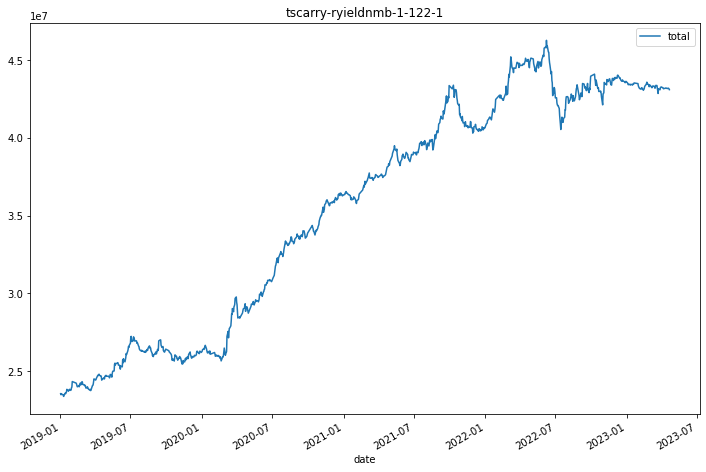

       sharpe        std  sortino
tenor                            
all      1.68  133918.66     2.44
6m      -0.11  139351.95    -0.18
1y      -0.53  222495.59    -0.79
2y       0.79  216872.04     1.25
3y       1.55  193931.30     2.37
4y       1.60  186938.05     2.50
5y       1.61  179424.72     2.51
6y       1.60  167786.56     2.45
7y       1.72  162036.81     2.67
8y       1.61  157776.31     2.47
9y       1.64  151102.82     2.50
10y      1.70  145620.30     2.55
11y      1.75  140639.10     2.62


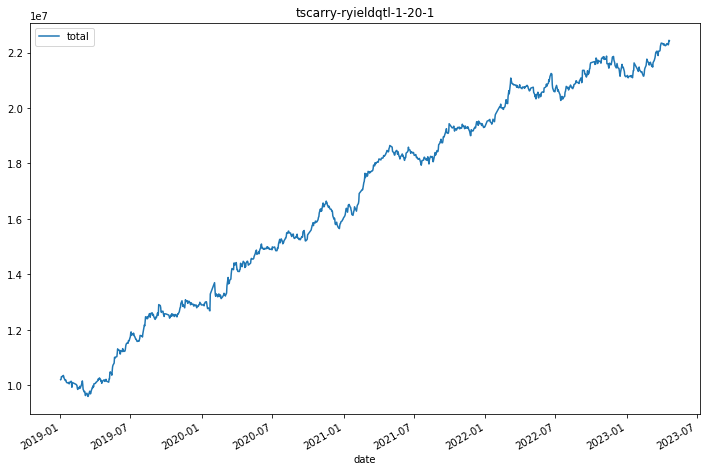

       sharpe       std  sortino
tenor                           
all      1.64  71613.95     2.62
6m       1.02  89281.04     1.62
1y       1.15  91179.52     1.77
2y       1.52  85843.50     2.47
3y       2.07  83034.08     3.38
4y       2.29  86401.92     4.02
5y       1.96  84443.96     3.48
6y       1.68  82139.29     2.86
7y       1.75  80827.00     3.01
8y       1.59  80485.01     2.64
9y       1.60  78684.53     2.65
10y      1.73  76361.82     2.82
11y      1.69  74098.86     2.73


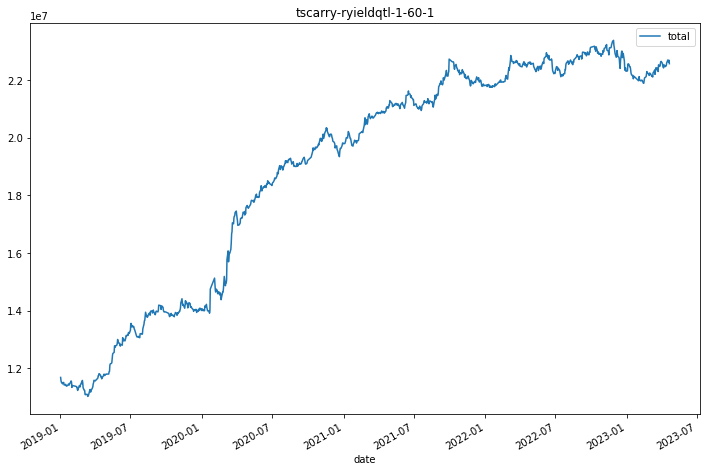

       sharpe        std  sortino
tenor                            
all      1.57   75045.16     2.49
6m      -0.50  102921.71    -0.80
1y       0.03   90847.39     0.04
2y       0.60   87458.26     1.04
3y       1.34   83501.50     2.27
4y       1.87   93682.83     3.37
5y       1.74   90831.87     3.05
6y       1.50   86774.78     2.54
7y       1.60   85291.25     2.73
8y       1.39   84120.82     2.30
9y       1.46   82650.88     2.38
10y      1.62   80223.99     2.62
11y      1.61   77766.88     2.58


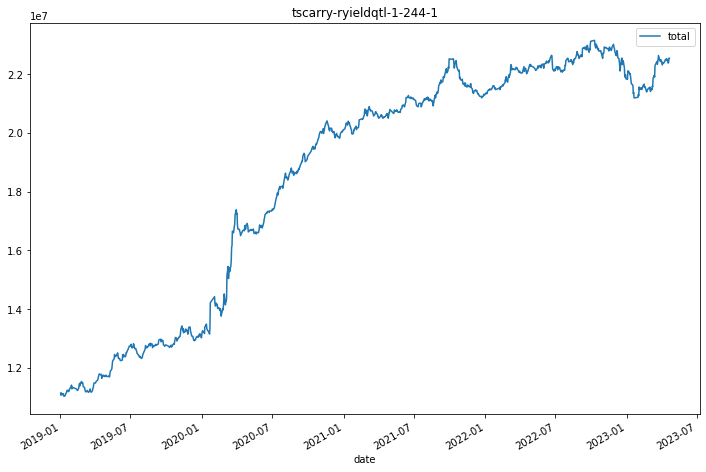

       sharpe        std  sortino
tenor                            
all      1.62   72672.55     2.45
6m      -0.38  112971.20    -0.61
1y       0.31   97220.77     0.49
2y       0.72   87405.12     1.11
3y       1.52   82904.20     2.36
4y       1.82   95804.35     3.01
5y       1.65   91679.04     2.68
6y       1.54   86615.49     2.48
7y       1.56   84256.48     2.52
8y       1.49   83566.31     2.36
9y       1.54   81814.32     2.45
10y      1.59   79098.89     2.53
11y      1.68   76604.72     2.66


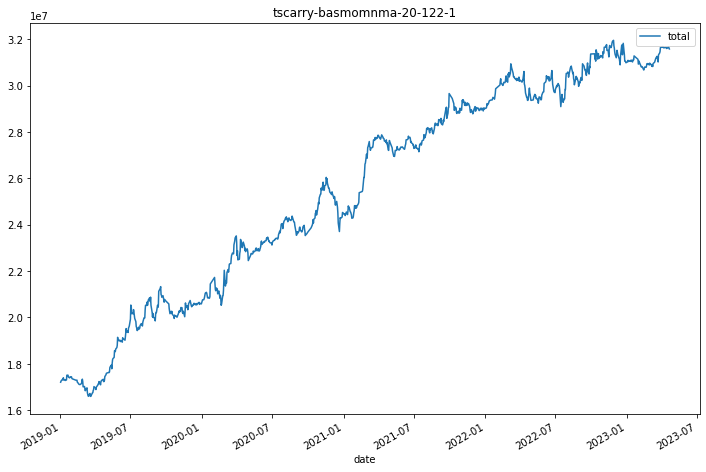

       sharpe        std  sortino
tenor                            
all      1.29  127969.89     1.86
6m       0.19  134494.94     0.27
1y       0.88  160677.33     1.47
2y       0.88  147219.65     1.41
3y       1.28  142810.13     2.03
4y       1.53  150023.74     2.38
5y       1.43  149073.81     2.25
6y       1.17  147171.09     1.79
7y       1.33  144407.11     2.06
8y       1.12  147712.92     1.70
9y       1.15  143111.73     1.75
10y      1.29  137546.85     1.93
11y      1.32  133273.34     1.96


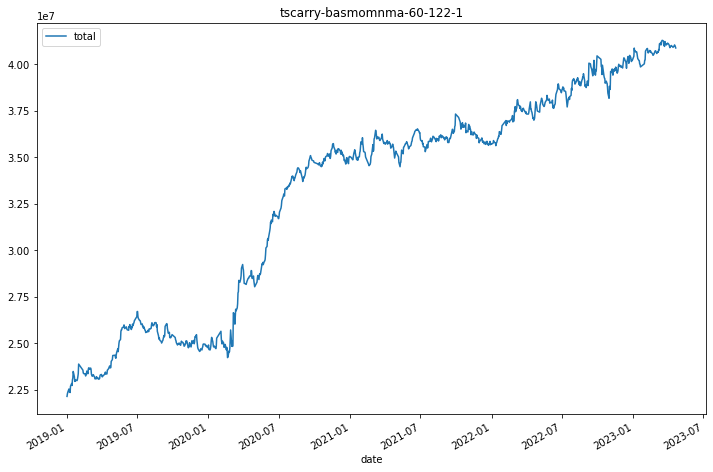

       sharpe        std  sortino
tenor                            
all      1.32  161818.85     1.98
6m       1.16  180719.13     2.70
1y       1.19  208952.88     2.31
2y       0.91  184976.07     1.59
3y       1.48  178048.75     2.61
4y       1.50  185438.26     2.60
5y       1.38  187656.72     2.23
6y       1.37  179734.32     2.20
7y       1.48  176778.85     2.41
8y       1.35  185396.11     2.14
9y       1.34  180345.70     2.10
10y      1.34  173886.31     2.10
11y      1.37  169721.21     2.13


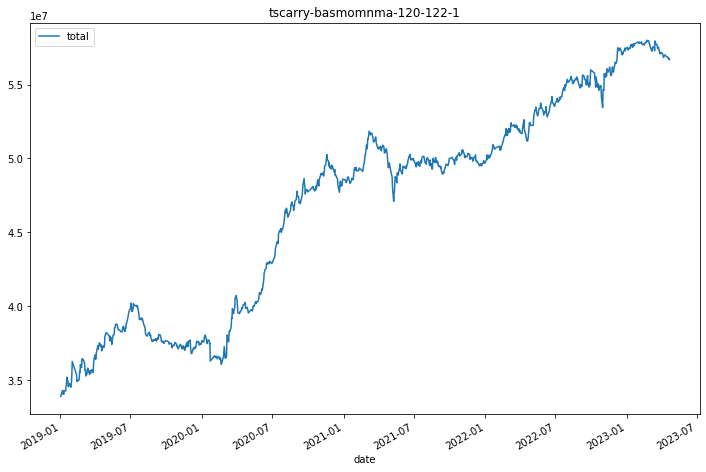

       sharpe        std  sortino
tenor                            
all      1.41  210220.43     2.07
6m       0.87  240304.43     1.49
1y       1.47  241327.85     2.53
2y       0.85  232826.90     1.28
3y       1.56  226885.82     2.43
4y       1.38  226474.33     2.09
5y       1.51  232327.83     2.30
6y       1.45  226636.09     2.22
7y       1.66  226721.26     2.59
8y       1.63  242067.15     2.54
9y       1.51  236346.73     2.34
10y      1.46  227048.07     2.25
11y      1.49  221173.92     2.28


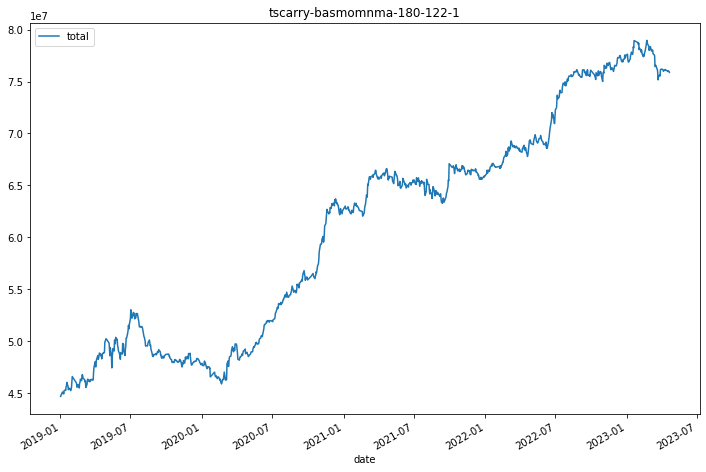

       sharpe        std  sortino
tenor                            
all      1.36  291149.38     1.97
6m      -0.07  286714.60    -0.10
1y       1.80  288592.53     2.94
2y       1.04  289783.20     1.74
3y       2.05  279069.82     3.45
4y       1.48  295116.69     2.42
5y       1.57  301650.53     2.57
6y       1.44  297059.50     2.29
7y       1.65  312428.16     2.66
8y       1.53  345508.90     2.41
9y       1.54  330613.50     2.39
10y      1.52  317703.08     2.34
11y      1.45  307536.56     2.20


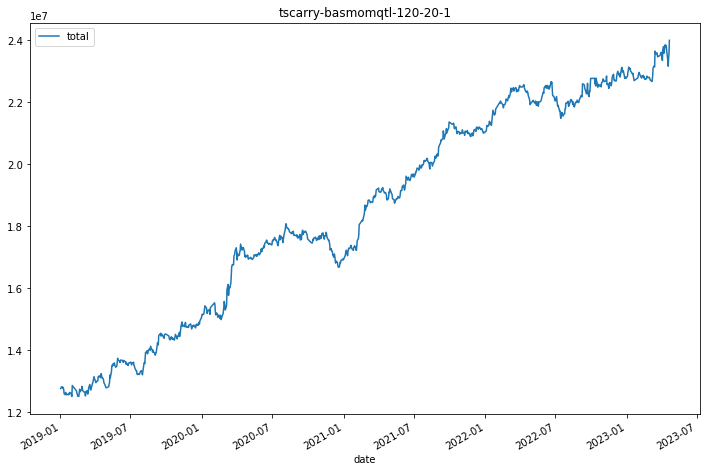

       sharpe        std  sortino
tenor                            
all      1.61   77750.72     2.65
6m       1.54  117901.62     2.53
1y       0.96  112128.81     1.58
2y       1.67   95627.04     2.72
3y       1.63   89258.10     2.68
4y       1.91   91641.74     3.20
5y       1.74   89064.69     2.93
6y       1.66   86396.20     2.78
7y       1.78   84588.78     2.98
8y       1.46   83538.75     2.42
9y       1.54   81652.42     2.56
10y      1.59   79069.72     2.62
11y      1.65   76794.54     2.70


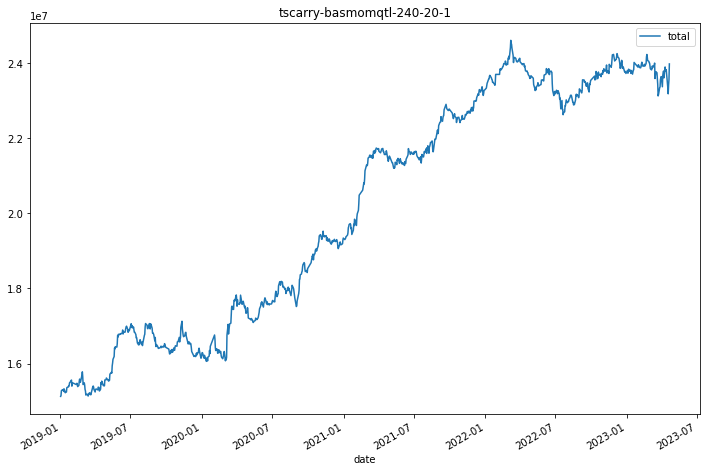

       sharpe        std  sortino
tenor                            
all      1.45   86585.68     2.32
6m       0.23  119190.72     0.33
1y       0.14  107132.68     0.20
2y       0.82   93514.29     1.18
3y       1.56   88822.73     2.34
4y       1.49   91370.41     2.35
5y       1.42   87302.59     2.26
6y       1.45   84417.81     2.29
7y       1.21   82658.98     1.92
8y       1.16   82787.33     1.81
9y       1.30   82387.98     2.06
10y      1.38   80295.11     2.19
11y      1.48   78401.02     2.34


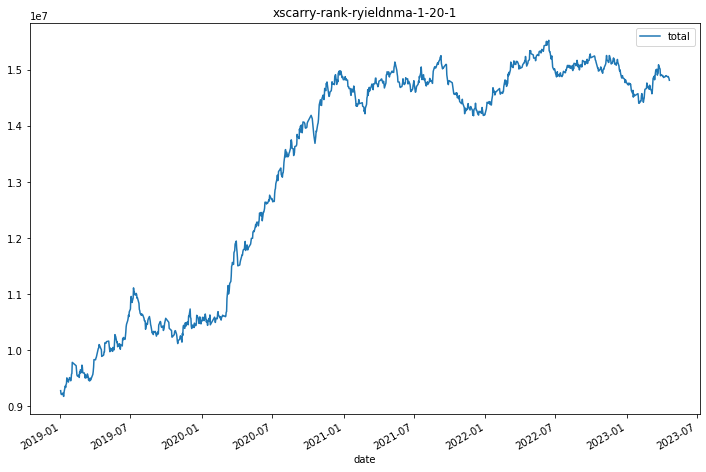

       sharpe       std  sortino
tenor                           
all      1.51  51509.08     2.37
6m      -0.39  53960.36    -0.69
1y      -0.34  52217.76    -0.54
2y       0.03  55503.82     0.04
3y       1.06  60793.01     1.64
4y       1.25  63332.87     2.02
5y       1.46  62442.43     2.38
6y       1.51  60439.47     2.44
7y       1.41  60347.11     2.33
8y       1.38  59140.00     2.29
9y       1.42  57522.13     2.34
10y      1.47  55955.50     2.40
11y      1.55  53892.74     2.48


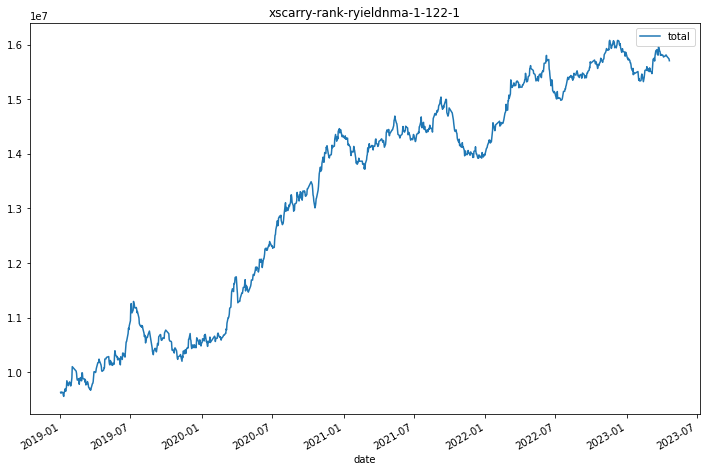

       sharpe       std  sortino
tenor                           
all      1.66  51556.81     2.62
6m       0.17  52118.79     0.28
1y       0.46  53295.68     0.67
2y       0.81  57803.44     1.24
3y       1.45  61295.82     2.31
4y       1.47  62342.67     2.44
5y       1.65  61784.82     2.79
6y       1.65  59951.89     2.76
7y       1.60  59848.70     2.71
8y       1.57  58564.61     2.63
9y       1.57  56680.22     2.59
10y      1.65  55231.29     2.71
11y      1.71  53135.49     2.75


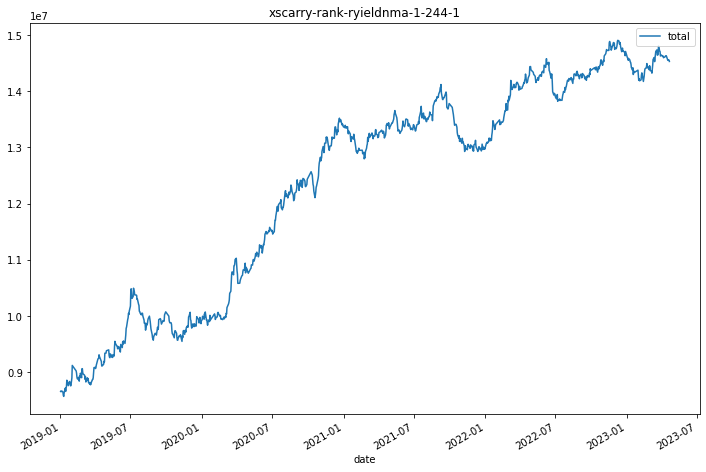

       sharpe       std  sortino
tenor                           
all      1.62  51102.50     2.60
6m       0.22  54330.13     0.36
1y       0.44  53608.98     0.67
2y       0.70  57563.83     1.08
3y       1.33  60000.89     2.13
4y       1.43  61126.97     2.39
5y       1.63  60921.73     2.77
6y       1.57  59076.81     2.63
7y       1.54  58870.58     2.62
8y       1.48  57338.89     2.50
9y       1.53  55236.68     2.53
10y      1.56  53673.86     2.58
11y      1.61  51674.34     2.60


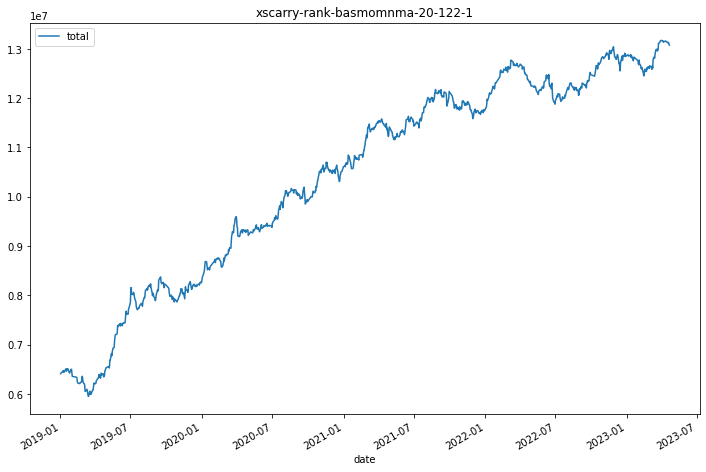

       sharpe       std  sortino
tenor                           
all      1.58  45410.29     2.44
6m       0.88  52454.18     1.45
1y       0.86  52015.16     1.32
2y       1.02  52441.26     1.56
3y       1.55  52310.55     2.41
4y       2.00  53743.24     3.23
5y       1.87  53382.74     2.95
6y       1.61  53231.21     2.55
7y       1.52  52460.83     2.42
8y       1.40  51243.24     2.23
9y       1.38  49725.40     2.20
10y      1.49  48248.80     2.36
11y      1.55  46499.30     2.42


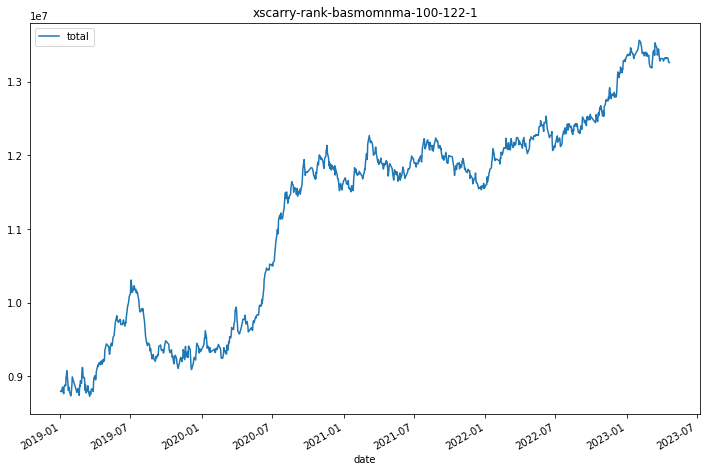

       sharpe       std  sortino
tenor                           
all      1.61  46486.55     2.56
6m       1.67  52292.02     2.83
1y       1.53  51887.05     2.51
2y       0.85  51113.83     1.35
3y       1.40  53566.62     2.31
4y       1.23  53383.14     2.04
5y       1.32  55555.33     2.16
6y       1.39  54182.21     2.25
7y       1.46  53418.14     2.41
8y       1.58  52323.46     2.58
9y       1.62  50471.15     2.63
10y      1.58  48920.27     2.56
11y      1.65  47108.21     2.62


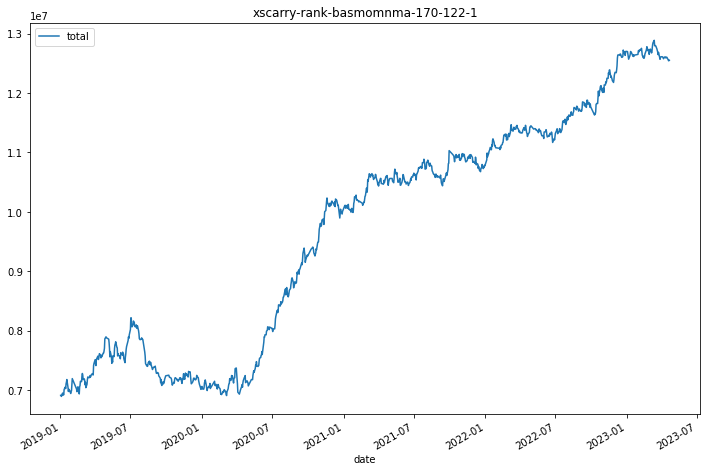

       sharpe       std  sortino
tenor                           
all      1.62  44810.24     2.57
6m       1.45  45873.40     2.40
1y       1.82  45368.31     3.10
2y       1.34  46950.29     2.26
3y       2.30  49849.57     3.93
4y       1.56  51195.56     2.62
5y       1.66  52796.90     2.72
6y       1.67  51175.35     2.71
7y       1.64  51103.86     2.71
8y       1.70  49866.73     2.76
9y       1.70  48075.37     2.74
10y      1.71  46691.57     2.74
11y      1.65  44965.71     2.61


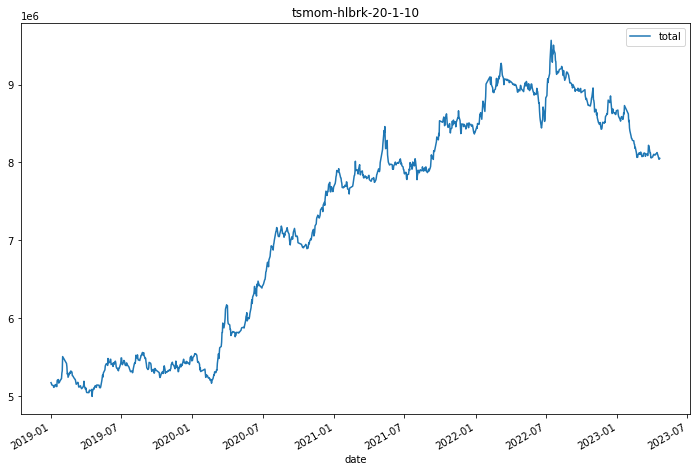

       sharpe       std  sortino
tenor                           
all      1.01  41532.99     1.47
6m      -1.92  45484.54    -2.40
1y      -0.99  54995.58    -1.34
2y       0.15  55003.13     0.21
3y       0.94  51145.48     1.36
4y       1.00  48242.67     1.45
5y       0.95  46146.56     1.39
6y       0.82  45185.38     1.22
7y       0.83  45404.48     1.27
8y       0.96  46299.75     1.42
9y       1.02  45154.95     1.51
10y      1.01  43835.64     1.49
11y      1.09  42805.81     1.61


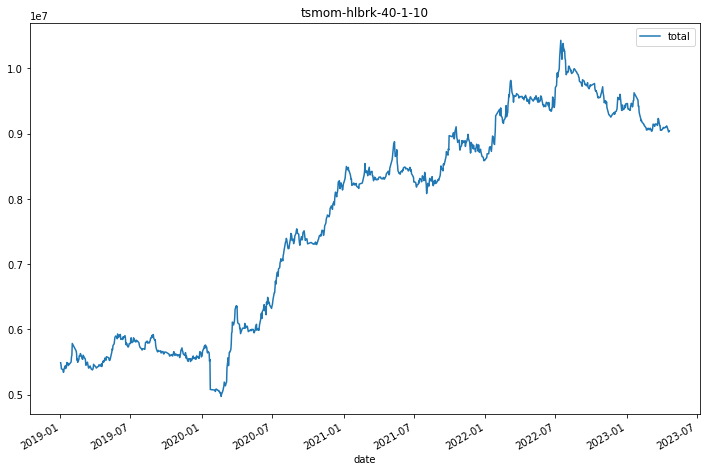

       sharpe       std  sortino
tenor                           
all      1.03  45863.84     1.46
6m      -1.51  43829.85    -1.86
1y      -0.57  53798.54    -0.78
2y       0.38  58213.65     0.59
3y       1.17  55577.69     1.80
4y       1.04  55002.92     1.44
5y       0.99  51936.99     1.39
6y       0.83  50593.34     1.19
7y       0.78  50012.69     1.15
8y       0.96  51403.53     1.39
9y       1.03  49923.17     1.48
10y      1.02  48431.06     1.46
11y      1.07  47318.38     1.53


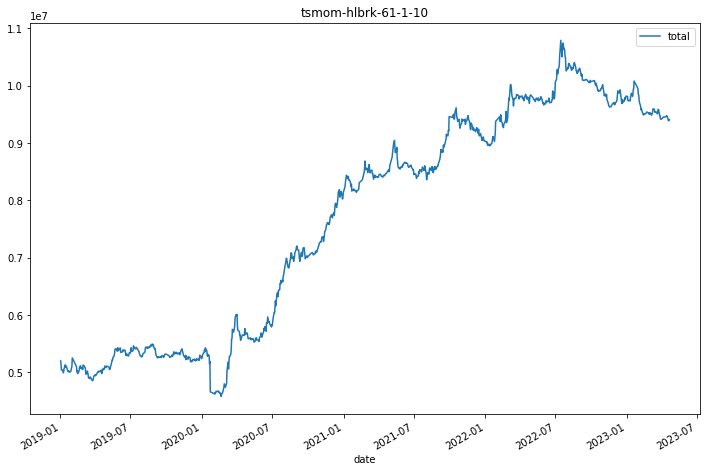

       sharpe       std  sortino
tenor                           
all      1.06  46471.81     1.48
6m      -1.53  43160.57    -1.92
1y      -0.46  53780.03    -0.61
2y       0.52  57795.02     0.80
3y       1.43  56570.91     2.22
4y       1.25  56473.08     1.68
5y       1.13  53310.17     1.54
6y       0.88  52096.54     1.23
7y       0.85  51089.89     1.21
8y       1.04  52006.76     1.48
9y       1.11  50636.73     1.57
10y      1.08  49115.15     1.53
11y      1.12  47866.51     1.58


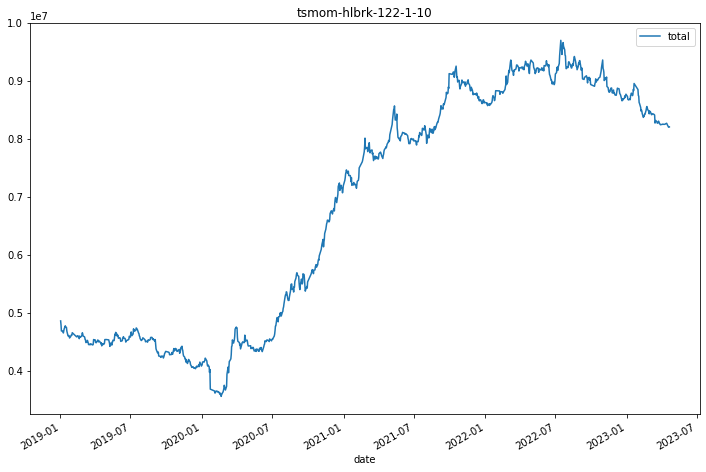

       sharpe       std  sortino
tenor                           
all      0.95  45064.73     1.33
6m      -2.27  47034.51    -2.85
1y      -1.24  55477.16    -1.65
2y       0.20  56547.05     0.28
3y       1.40  57075.22     2.05
4y       1.10  54653.43     1.55
5y       0.93  51125.44     1.32
6y       0.67  49272.30     0.95
7y       0.74  49028.48     1.07
8y       0.92  50570.24     1.33
9y       1.01  49479.81     1.46
10y      1.02  48046.01     1.46
11y      1.01  46656.02     1.44


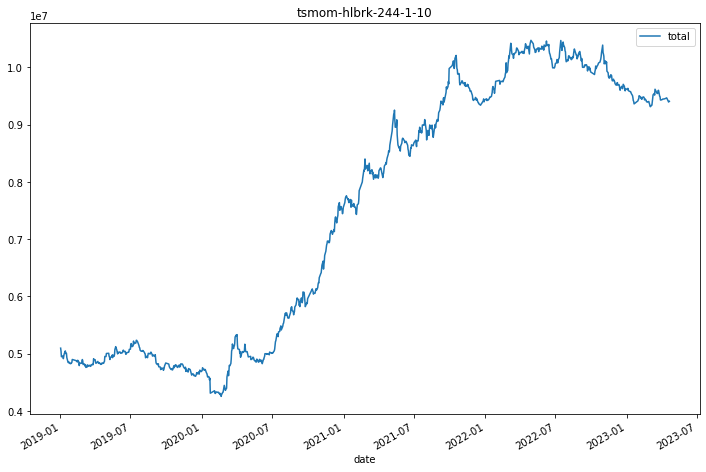

       sharpe       std  sortino
tenor                           
all      1.10  44723.72     1.52
6m      -2.08  40780.43    -2.79
1y      -1.27  47026.22    -1.79
2y       0.59  58468.28     0.87
3y       1.61  58265.75     2.43
4y       1.34  54932.05     1.95
5y       1.18  51016.98     1.71
6y       1.00  48213.93     1.45
7y       1.06  48692.55     1.56
8y       1.06  51068.67     1.55
9y       1.16  49718.76     1.68
10y      1.18  48358.22     1.71
11y      1.21  47067.89     1.73


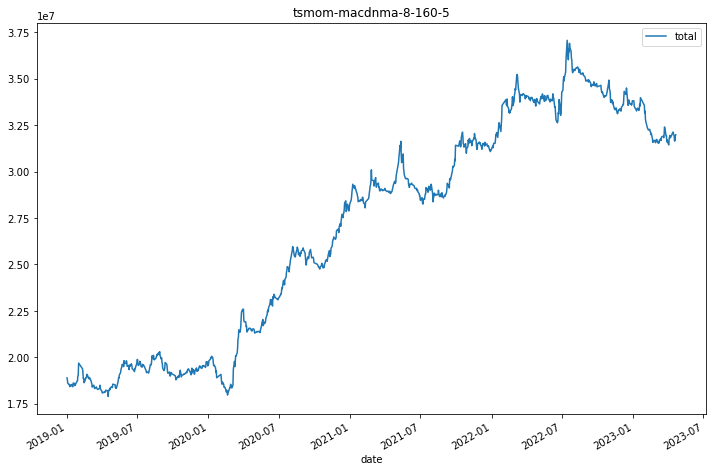

       sharpe        std  sortino
tenor                            
all      1.05  159771.76     1.51
6m      -1.43  188498.01    -1.82
1y      -0.51  219818.31    -0.70
2y       0.43  220945.02     0.64
3y       1.09  205110.54     1.60
4y       1.14  194665.76     1.70
5y       0.95  184282.85     1.42
6y       0.83  179278.10     1.26
7y       0.83  180093.41     1.27
8y       0.95  182651.24     1.43
9y       0.96  175652.75     1.43
10y      0.94  170139.98     1.40
11y      1.04  166252.23     1.54


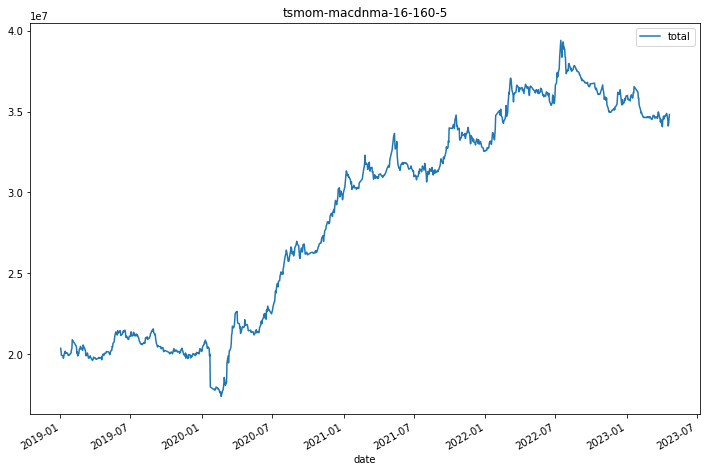

       sharpe        std  sortino
tenor                            
all      1.04  175394.32     1.42
6m      -0.88  185966.64    -1.15
1y      -0.50  212384.89    -0.67
2y       0.50  228206.01     0.75
3y       1.29  218507.32     1.93
4y       1.11  217522.68     1.47
5y       0.90  204387.91     1.22
6y       0.78  198380.46     1.08
7y       0.76  197824.86     1.07
8y       0.95  201093.77     1.34
9y       1.01  193180.48     1.42
10y      0.99  186883.31     1.38
11y      1.03  182317.91     1.44


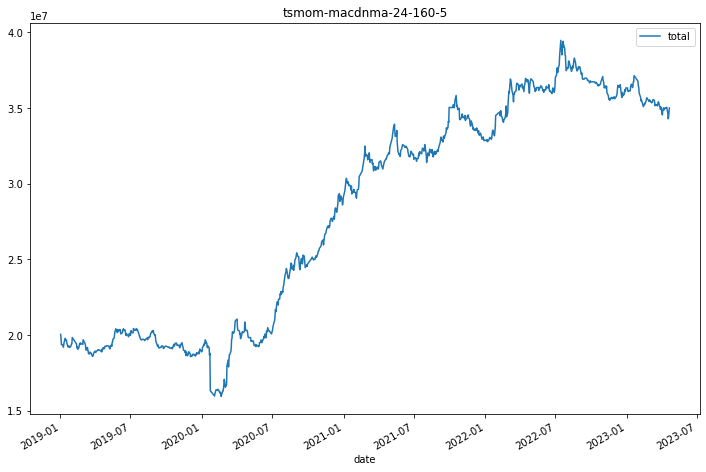

       sharpe        std  sortino
tenor                            
all      1.01  181814.65     1.34
6m      -1.10  178324.76    -1.49
1y      -0.54  212814.68    -0.72
2y       0.47  228536.62     0.70
3y       1.40  225937.57     2.14
4y       1.13  227955.96     1.44
5y       0.90  213315.39     1.16
6y       0.73  206410.51     0.96
7y       0.73  205460.16     0.99
8y       0.94  208166.62     1.29
9y       1.02  200561.87     1.39
10y      1.01  193976.54     1.37
11y      1.01  188793.77     1.37


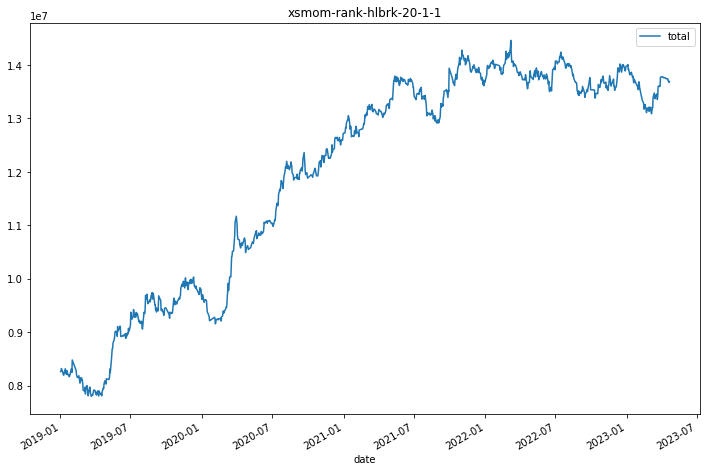

       sharpe       std  sortino
tenor                           
all      1.23  58651.27     1.96
6m       0.10  66329.96     0.17
1y       0.13  67412.51     0.20
2y       0.23  72692.32     0.39
3y       0.90  69880.65     1.44
4y       1.28  73031.53     2.15
5y       1.03  71563.55     1.74
6y       1.00  69857.47     1.67
7y       0.77  68267.69     1.28
8y       0.88  66440.36     1.46
9y       0.99  64972.83     1.64
10y      1.12  63086.58     1.85
11y      1.21  61007.72     1.96


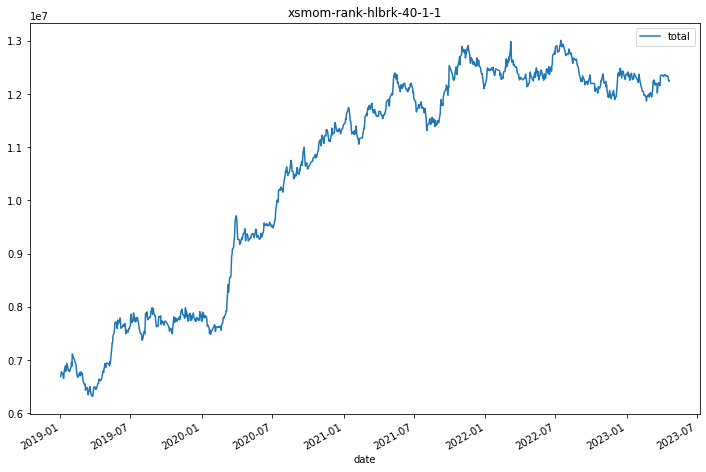

       sharpe       std  sortino
tenor                           
all      1.08  59944.29     1.70
6m       0.21  65141.52     0.32
1y       0.08  65829.47     0.13
2y       0.23  74175.30     0.37
3y       0.85  71811.99     1.37
4y       1.21  73648.59     2.03
5y       1.06  72303.21     1.78
6y       0.85  70817.65     1.43
7y       0.63  69169.82     1.04
8y       0.74  67434.98     1.22
9y       0.88  66128.01     1.43
10y      0.99  64200.95     1.60
11y      1.09  62161.34     1.73


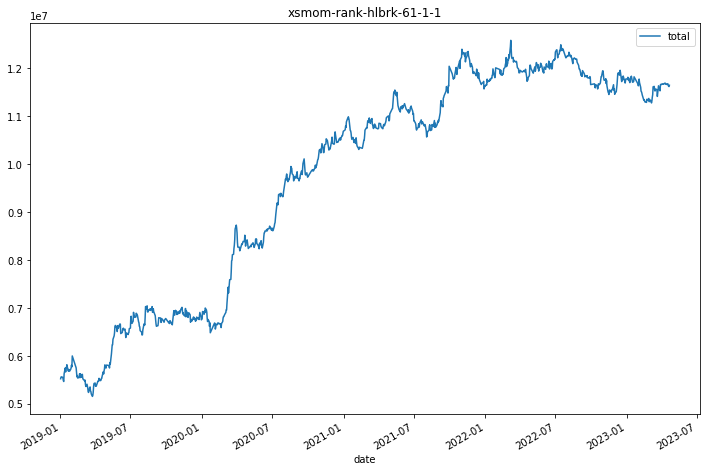

       sharpe       std  sortino
tenor                           
all      1.04  60003.40     1.62
6m      -0.06  63653.56    -0.09
1y      -0.12  62910.93    -0.18
2y       0.33  72615.20     0.55
3y       0.98  71293.66     1.62
4y       1.33  73284.17     2.24
5y       1.17  72144.62     1.94
6y       0.89  70614.33     1.47
7y       0.68  68725.44     1.10
8y       0.78  67218.27     1.27
9y       0.87  65827.30     1.42
10y      0.95  63953.73     1.52
11y      1.05  61967.35     1.66


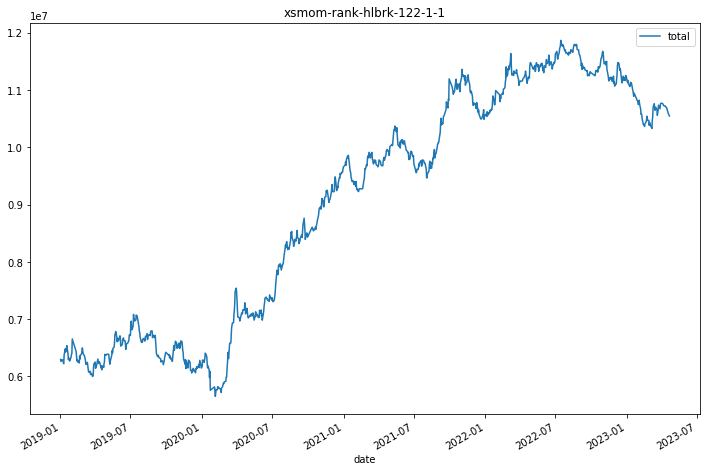

       sharpe       std  sortino
tenor                           
all      0.98  58857.79     1.48
6m      -1.76  62710.51    -2.85
1y      -0.66  60209.56    -1.03
2y       0.32  70150.29     0.52
3y       1.05  69431.78     1.70
4y       1.00  70563.46     1.59
5y       0.89  70023.87     1.41
6y       0.72  67833.68     1.13
7y       0.62  66742.69     0.97
8y       0.68  65471.34     1.07
9y       0.84  64123.62     1.32
10y      0.93  62206.42     1.44
11y      0.99  60383.85     1.52


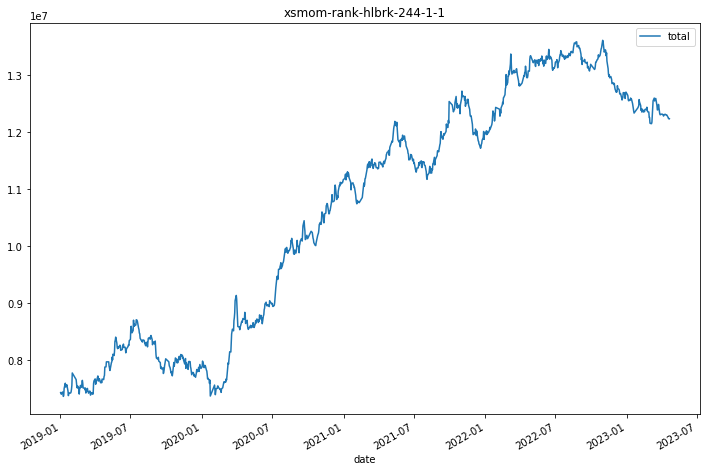

       sharpe       std  sortino
tenor                           
all      1.21  57528.05     1.84
6m      -2.64  54496.37    -3.99
1y      -0.82  56562.50    -1.21
2y       0.33  68598.28     0.52
3y       1.10  68566.53     1.78
4y       1.07  68774.05     1.73
5y       1.04  67434.60     1.68
6y       0.97  65365.45     1.54
7y       0.84  64693.97     1.32
8y       0.86  63457.72     1.36
9y       1.01  61865.36     1.58
10y      1.11  59845.42     1.71
11y      1.19  58075.21     1.82


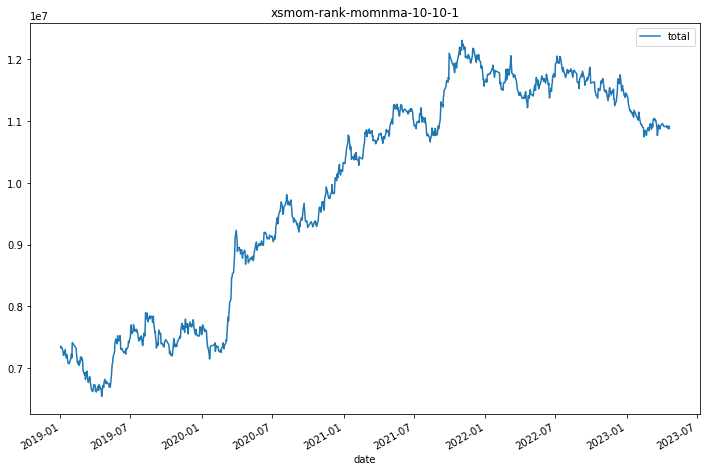

       sharpe       std  sortino
tenor                           
all      0.99  58269.22     1.59
6m      -1.26  62625.99    -1.81
1y      -0.30  65744.03    -0.45
2y       0.05  71385.66     0.08
3y       0.62  69631.76     0.99
4y       0.96  71686.53     1.60
5y       0.76  70276.35     1.27
6y       0.70  68877.72     1.18
7y       0.58  67040.52     0.98
8y       0.72  65801.54     1.21
9y       0.84  64423.10     1.40
10y      0.97  62396.17     1.59
11y      1.02  60469.88     1.66


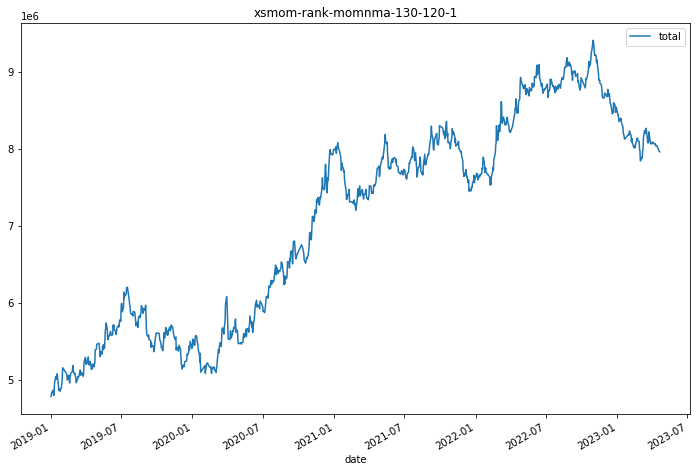

       sharpe       std  sortino
tenor                           
all      0.83  54974.45     1.25
6m      -2.86  52617.03    -4.52
1y      -0.57  56949.52    -0.91
2y       0.17  64440.45     0.25
3y       0.74  66438.43     1.16
4y       0.67  66050.03     1.05
5y       0.75  64298.85     1.17
6y       0.68  62617.50     1.06
7y       0.64  61964.23     1.00
8y       0.66  60853.84     1.04
9y       0.72  59025.47     1.11
10y      0.79  56994.94     1.20
11y      0.83  55466.33     1.25


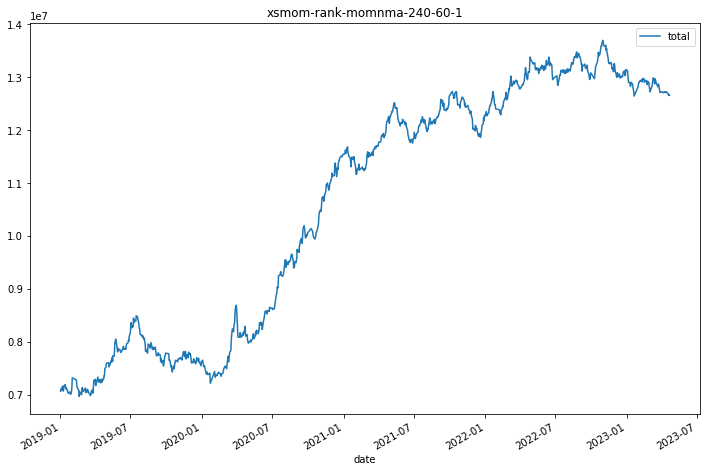

       sharpe       std  sortino
tenor                           
all      1.39  52915.66     2.19
6m      -2.07  50506.02    -3.41
1y      -0.34  56084.79    -0.54
2y       0.36  58531.50     0.58
3y       1.59  60610.12     2.58
4y       1.40  61823.65     2.23
5y       1.29  60486.95     2.10
6y       1.24  59744.77     2.02
7y       1.26  58683.32     2.05
8y       1.23  57826.10     2.00
9y       1.31  56108.07     2.10
10y      1.34  54307.30     2.13
11y      1.39  52972.47     2.18


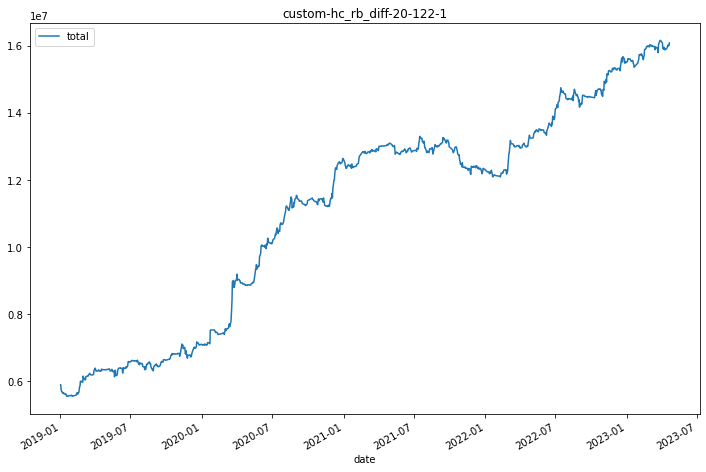

       sharpe       std  sortino
tenor                           
all      1.68  69949.09     2.68
6m       2.37  74984.18     4.58
1y       2.66  74058.64     4.76
2y       1.46  67794.91     2.56
3y       2.25  68689.48     3.93
4y       2.24  69895.34     3.92
5y       2.00  69887.40     3.30
6y       1.70  68126.68     2.77
7y       1.68  70439.52     2.65
8y       1.72  71359.74     2.80
9y       1.68  69949.09     2.68
10y      1.68  69949.09     2.68
11y      1.68  69949.09     2.68


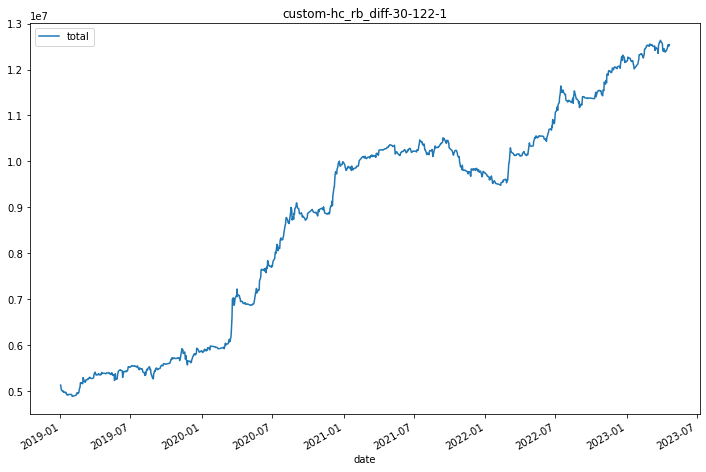

       sharpe       std  sortino
tenor                           
all      1.67  54724.88     2.59
6m       2.32  55798.53     4.26
1y       2.73  56232.93     4.81
2y       1.42  51251.43     2.49
3y       2.27  53392.66     3.99
4y       2.16  53220.40     3.66
5y       1.92  53193.13     3.07
6y       1.63  52240.96     2.58
7y       1.68  54962.51     2.58
8y       1.73  55672.18     2.71
9y       1.67  54724.88     2.59
10y      1.67  54724.88     2.59
11y      1.67  54724.88     2.59


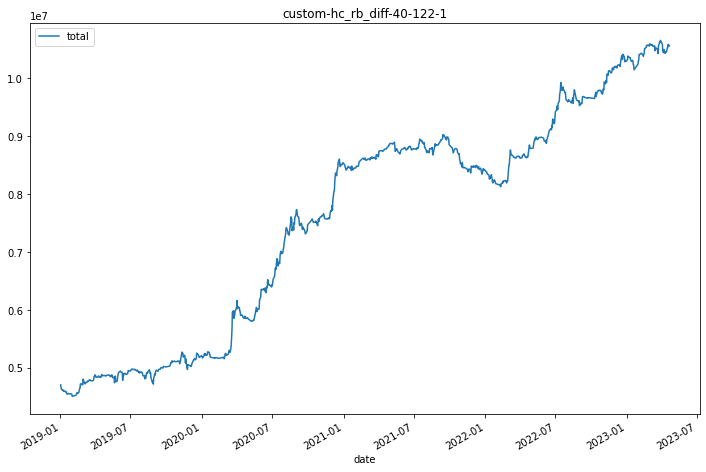

       sharpe       std  sortino
tenor                           
all      1.66  46251.67     2.53
6m       2.28  43905.45     3.96
1y       2.68  45855.65     4.52
2y       1.38  41386.07     2.35
3y       2.26  44588.88     3.90
4y       2.07  44153.64     3.41
5y       1.84  44135.42     2.88
6y       1.56  43621.57     2.41
7y       1.68  46340.99     2.53
8y       1.73  46931.72     2.65
9y       1.66  46251.67     2.53
10y      1.66  46251.67     2.53
11y      1.66  46251.67     2.53


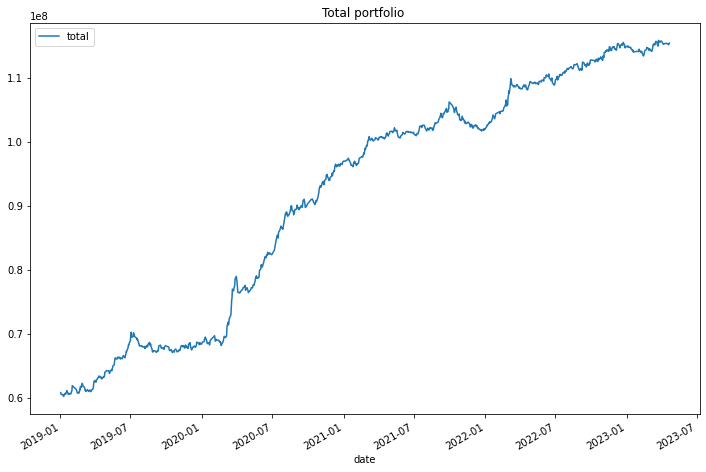

       sharpe        std  sortino
tenor                            
all      2.60  231860.17     4.24
6m       1.22  246380.16     2.52
1y       1.92  244476.92     3.54
2y       1.76  266287.06     2.98
3y       2.92  280871.39     5.12
4y       2.90  290563.92     5.24
5y       2.76  288889.43     5.02
6y       2.57  277578.81     4.54
7y       2.57  278219.75     4.58
8y       2.60  272256.44     4.56
9y       2.63  261987.17     4.56
10y      2.67  253582.94     4.57
11y      2.70  243890.66     4.53
pnl per trade: product
rb     45.247531
hc     71.799762
i      97.193380
j      64.321676
jm     39.557468
ru     35.690757
FG     36.607626
cu     13.556533
al     21.124676
zn     10.823646
sn     39.617632
l      23.842582
pp     35.414799
v      46.201286
TA     55.101093
sc    151.781410
m      19.488702
RM     14.974060
y      50.283692
p      58.129572
OI     35.366470
a       1.414185
c       1.357151
CF     13.081741
jd     28.215814
AP     98.819859
SM     18.673806
eb    10

In [41]:
file_folder = "C:\\dev\\data\\data_cache\\"

start_date = datetime.date(2011,1,1)
end_date = datetime.date(2023,4,21)

scenario_map = {
    'test': scenarios_test,
    'elite': scenarios_elite,
}

shift_mode = 2
rev_char = '!'
exec_mode = 'open'
total_risk = 500_000.0
asset_scaling = False
std_win = 20
pnl_tenors = ['6m', '1y', '2y', '3y', '4y', '5y', '6y', '7y', '8y', '9y', '10y', '11y']

# product_list = product_grouping_partial['ind'] + product_grouping_partial['petro'] + product_grouping_partial['ags']
# product_list = product_grouping_complete['ind'] + product_grouping_complete['petro'] + product_grouping_complete['ags']

product_list = ['rb', 'hc', 'i', 'j', 'jm', 'ru', 'FG', 'cu', 'al', 'zn', 'sn',
                'l', 'pp', 'v', 'TA', 'sc', 'm', 'RM', 'y', 'p', 'OI', 'a', 'c', 'CF', 'jd',
                'AP', 'SM', 'eb', 'eg', 'UR', 'ss', 'lu', 'lh', 'ni']

# product_list = ind_all_mkts + ags_all_mkts
# ind_all_mkts = ind_metal_mkts, petro_chem_mkts, ags_all_mkts = ags_oil_mkts + ags_soft_mkts

scenario_name = 'test'

run_key = f'{roll_name}_{scenario_name}'
scenarios = scenario_map[scenario_name]

run_pos_sum = True
pos_sum = pd.DataFrame()
scen_names[run_key] = []
scen_metrics[run_key] = []
scen_stats[run_key] = []

port_start = pd.to_datetime('2019-01-01')

for scen in scenarios:
    sim_type = scen[0]
    signal_name = scen[1]
    weight = scen[2]
    win = scen[3]
    ma_win = scen[4]
    rebal = scen[5]
    pos_map = scen[6]
    params = scen[7]
    run_name = '-'.join([sim_type, signal_name, str(win), str(ma_win), str(rebal)])
    
    run_args = {}
    run_args['shift_mode'] = shift_mode
    run_args['exec_mode'] = exec_mode
    run_args['total_risk'] = total_risk
    run_args['asset_scaling'] = asset_scaling
    run_args['pnl_tenors'] = pnl_tenors
    run_args['std_win'] = std_win
    run_args['start_date'] = start_date
    run_args['end_date'] = end_date    
    
    if (sim_type[:2] in ['ts', 'xs']):
        run_args['product_list'] = product_list
        run_args['rev_char'] = rev_char
        run_args['xs_signal'] = ''
        run_args['xs_params'] = {'cutoff': 0.2}
        run_args['signal_name'] = signal_name
        run_args['win'] = win
        run_args['ma_win'] = ma_win
        run_args['rebal_freq'] = rebal
        run_args['params'] = params
        run_args['pos_map'] = pos_map
        run_args['xs_params'] = {'cutoff': 0.2}
        run_args['signal_func'] = default_signal_gen
        if 'xs' in sim_type:
            sim_split = sim_type.split('-')
            if len(sim_split)>1:
                run_args['xs_signal'] = sim_split[1]
            else:
                run_args['xs_signal'] = 'rank_cutoff'    
        if len(scen) > 8:
            run_args['xs_params'] = {'cutoff': scen[8]}
    elif sim_type == 'custom':
        if signal_name == 'hc_rb_diff':
            run_args['product_list'] = [
                'rb', 'hc', 'i', 'j', 'jm', 'FG', 'v', 'UR',
                'cu', 'al', 'zn', 'ni', 'sn', 'ss',
            ]
            run_args['signal_func'] = hc_rb_diff
            run_args['win'] = win
    bt_metrics = run_backtest(df, run_args)
    scen_names[run_key].append(run_name)
    scen_metrics[run_key].append(bt_metrics)
    pnl_stats = bt_metrics.calculate_pnl_stats(shift=0, tenors=pnl_tenors, perf_metrics=['sharpe', 'std', 'sortino', 'calmar'])
    scen_stats[run_key].append(pnl_stats)
    pnl_stats['portfolio_cumpnl'][port_start:].plot(title=run_name)
    plt.show()
    perf_stats = transform_output(pnl_stats)
    print(perf_stats.round(2))
    #print('pnl per trade: %s, turnover: %s\n' % (pnl_stats['pnl_per_trade'], pnl_stats['turnover']))
    
    if run_pos_sum:
        pos_sum = pos_sum.add(bt_metrics.holdings * weight, fill_value = 0)

df_pxchg = get_px_chg(df, exec_mode=exec_mode, chg_type='pct', contract='c1')
df_pxchg = df_pxchg[product_list].reindex(index=pos_sum.index)

bt_met = MetricsBase(holdings=pos_sum, returns=df_pxchg)
port_stats = bt_met.calculate_pnl_stats(shift=0, tenors=pnl_tenors, perf_metrics=['sharpe', 'std', 'sortino', 'calmar'])
port_stats['portfolio_cumpnl'][port_start:].plot(title="Total portfolio ")
plt.show()
perf_stats = transform_output(port_stats)
print(perf_stats.round(2))
print('pnl per trade: %s, turnover: %s\n' % (port_stats['pnl_per_trade'], port_stats['turnover']))
bt_empirics[run_key] = bt_met

bt_metrics = bt_met

close_prices = df.loc[:, (df.columns.get_level_values(1)=='c1') & (df.columns.get_level_values(2)=='close')].droplevel([1, 2], axis=1)
close_prices = close_prices[product_list]
open_prices = df.loc[:, (df.columns.get_level_values(1)=='c1') & (df.columns.get_level_values(2)=='open')].droplevel([1, 2], axis=1)
open_prices = open_prices[product_list]
asset_pnl = bt_met.calculate_daily_pnl(open_prices, close_prices, mode='ret')
port_pnl = asset_pnl.sum(axis=1).cumsum().to_frame('total')
holdings[run_key] = pos_sum[product_list].divide(close_prices[product_list])
print(port_pnl[-40:])
port_pnl.to_csv(file_folder + "port_pnl.csv")


In [51]:
holdings[run_key]['2020-01-01':]['FG'].describe()

count     798.000000
mean     -314.830758
std      1435.218581
min     -3853.557137
25%     -1309.510441
50%      -282.533890
75%       606.409352
max      4735.543159
Name: FG, dtype: float64

In [21]:
port_pnl.to_csv(file_folder + "port_pnl.csv")

<AxesSubplot:xlabel='date'>

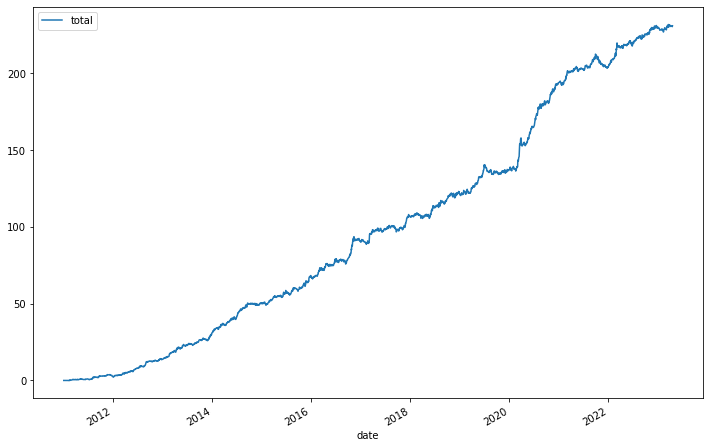

In [29]:
port_stats['portfolio_cumpnl'].plot()

In [16]:
port_stats = bt_met.calculate_pnl_stats(shift=0, tenors=pnl_tenors)


In [13]:
ts1 = bt_empirics['hot_elite'].calculate_pnl_stats(shift=0, tenors=pnl_tenors)['portfolio_cumpnl']
ts2 = bt_empirics['hot_test'].calculate_pnl_stats(shift=0, tenors=pnl_tenors)['portfolio_cumpnl']


# holding and std for strategy group

In [13]:
file_folder = "C:\\dev\\data\\data_cache\\"

#port_stats['portfolio_cumpnl'].to_csv(file_folder + "port_pnl_est.csv")

print(bt_met.holdings)

print(port_stats['portfolio_pnl'].resample('M').sum()[-60:])


product             rb          hc            i           j           jm  \
date                                                                       
2011-01-05    0.000000    0.000000     0.000000    0.000000     0.000000   
2011-01-06    0.000000    0.000000     0.000000    0.000000     0.000000   
2011-01-07    0.000000    0.000000     0.000000    0.000000     0.000000   
2011-01-10    0.000000    0.000000     0.000000    0.000000     0.000000   
2011-01-11    0.000000    0.000000     0.000000    0.000000     0.000000   
...                ...         ...          ...         ...          ...   
2023-02-24  604.808482  735.324362  2549.031610  724.911486  1243.721959   
2023-02-27  806.274123  848.178152  2688.410716  760.985279  1056.453553   
2023-02-28  643.979541  630.660872  2977.451883  825.346491  1280.977788   
2023-03-01  675.590222  849.247004  3181.068205  760.230648  1016.117231   
2023-03-02  702.130979  828.766438  3425.999538  870.561510  1075.949249   

product    

In [15]:
tenors = ['1y', '2y', '3y', '5y', '7y', '9y', '11y']
data_list = []
run_key = 'hot_test'
for scen_name, scen, pl_stat in zip(scen_names[run_key], scenarios, scen_stats[run_key]):
    weight = scen[2]
    data = [scen_name, weight] + [pl_stat['std'].loc[f'std_{ten}'] for ten in tenors] + [pl_stat['sharpe'].loc[f'sharpe_{ten}'] for ten in tenors]
    data_list.append(data)
    
data_df = pd.DataFrame(data_list, columns=['strat_name', 'weight'] + [f'std_{ten}' for ten in tenors] + [f'sharpe_{ten}' for ten in tenors])
data_df = data_df.set_index('strat_name')
data_df

,weight,std_1y,std_2y,std_3y,std_5y,std_7y,std_9y,std_11y,sharpe_1y,sharpe_2y,sharpe_3y,sharpe_5y,sharpe_7y,sharpe_9y,sharpe_11y
strat_name,,,,,,,,,,,,,,,
tscarry-ryieldnmb-1-122-1,1.0000,0.444991,0.433744,0.387863,0.358849,0.324074,0.302206,0.281278,-0.534071,0.791143,1.553429,1.608539,1.723025,1.644174,1.754697
tscarry-ryieldqtl-1-20-1,0.8000,0.182359,0.171687,0.166068,0.168888,0.161654,0.157369,0.148198,1.154713,1.522251,2.069300,1.961816,1.754628,1.603318,1.687850
tscarry-ryieldqtl-1-60-1,0.8000,0.181695,0.174917,0.167003,0.181664,0.170583,0.165302,0.155534,0.025135,0.604052,1.336619,1.736048,1.595644,1.455795,1.606665
tscarry-ryieldqtl-1-244-1,0.8000,0.194442,0.174810,0.165808,0.183358,0.168513,0.163629,0.153209,0.314082,0.715204,1.520397,1.646973,1.558537,1.536013,1.681613
tscarry-basmomnma-20-122-1,0.5000,0.321355,0.294439,0.285620,0.298148,0.288814,0.286223,0.266547,0.884553,0.882624,1.276281,1.431536,1.325146,1.153423,1.322424
tscarry-basmomnma-60-122-1,0.4200,0.417906,0.369952,0.356097,0.375313,0.353558,0.360691,0.339442,1.193783,0.912255,1.476989,1.379068,1.479869,1.335746,1.369299
tscarry-basmomnma-120-122-1,0.3500,0.482656,0.465654,0.453772,0.464656,0.453443,0.472693,0.442348,1.466634,0.846456,1.564389,1.507238,1.660713,1.505245,1.487886
tscarry-basmomnma-180-122-1,0.3500,0.577185,0.579566,0.558140,0.603301,0.624856,0.661227,0.615073,1.799977,1.044011,2.054955,1.566053,1.650943,1.538483,1.445634
tscarry-basmomqtl-120-20-1,2.0000,0.224258,0.191254,0.178516,0.178129,0.169178,0.163305,0.153589,0.962137,1.667497,1.633340,1.737575,1.781443,1.542783,1.652170


In [16]:
data_df.to_csv("port_perf_check.csv")

In [18]:
scenarios

[('tscarry', 'ryieldnmb', 2.0, 1, 120, 1, (None, {}, ''), [0.0, 0.0]),
 ('tscarry', 'basmomnma', 1.0, 100, 120, 1, (None, {}, ''), [0.0, 0.0]),
 ('tscarry', 'basmomnma', 1.0, 170, 120, 1, (None, {}, ''), [0.0, 0.0]),
 ('xscarry-rank_cutoff',
  'ryieldnma',
  1.9,
  1,
  20,
  1,
  (None, {}, ''),
  [0.0, 0.0],
  0.2),
 ('xscarry-rank_cutoff',
  'ryieldnma',
  2.1,
  1,
  110,
  1,
  (None, {}, ''),
  [0.0, 0.0],
  0.2),
 ('xscarry-rank_cutoff',
  'basmomnma',
  2.5,
  80,
  120,
  5,
  (None, {}, ''),
  [0.0, 0.0],
  0.2),
 ('xscarry-rank_cutoff',
  'basmomnma',
  2.5,
  150,
  120,
  5,
  (None, {}, ''),
  [0.0, 0.0],
  0.2),
 ('tsmom', 'hlbrk', 1.1, 10, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
 ('tsmom', 'hlbrk', 0.9, 30, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
 ('tsmom', 'hlbrk', 0.9, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
 ('tsmom',
  'macdnma',
  0.22,
  8,
  160,
  5,
  (<function pycmqlib3.analytics.tstool.response_curve(y, response='linear', param=1)>,
   {'response': '

# asset level cum pnl

product           rb        hc         i         j        jm        ru  \
sharpe      0.323876  0.809957  0.724711  0.475860  0.428585  0.562446   
sharpe_6m  -0.890350  0.134250  1.753153       NaN       NaN -0.504611   
sharpe_1y  -0.267060  1.519788  0.586632 -1.891429       NaN  0.957608   
sharpe_2y  -0.190253  1.125374  0.300596  0.216499  0.535823  0.590105   
sharpe_3y   0.494870  1.888858  1.184239 -0.237671  0.420748  0.337683   
sharpe_4y   0.449147  1.456568  0.949912  0.112318  0.035228  0.506445   
sharpe_5y   0.199359  1.256697  0.883913  0.001861  0.174178  0.603708   
sharpe_6y   0.094969  1.078674  0.749858  0.471455  0.037831  0.671506   
sharpe_7y   0.088793  0.990913  0.828085  0.557333  0.526836  0.562704   
sharpe_8y   0.314868  0.856111  0.783751  0.652089  0.409960  0.513486   
sharpe_9y   0.331092  0.809957  0.738972  0.578575  0.449763  0.534781   
sharpe_10y  0.311325  0.809957  0.724711  0.650699  0.428585  0.591412   
sharpe_11y  0.323876  0.809957  0.7247

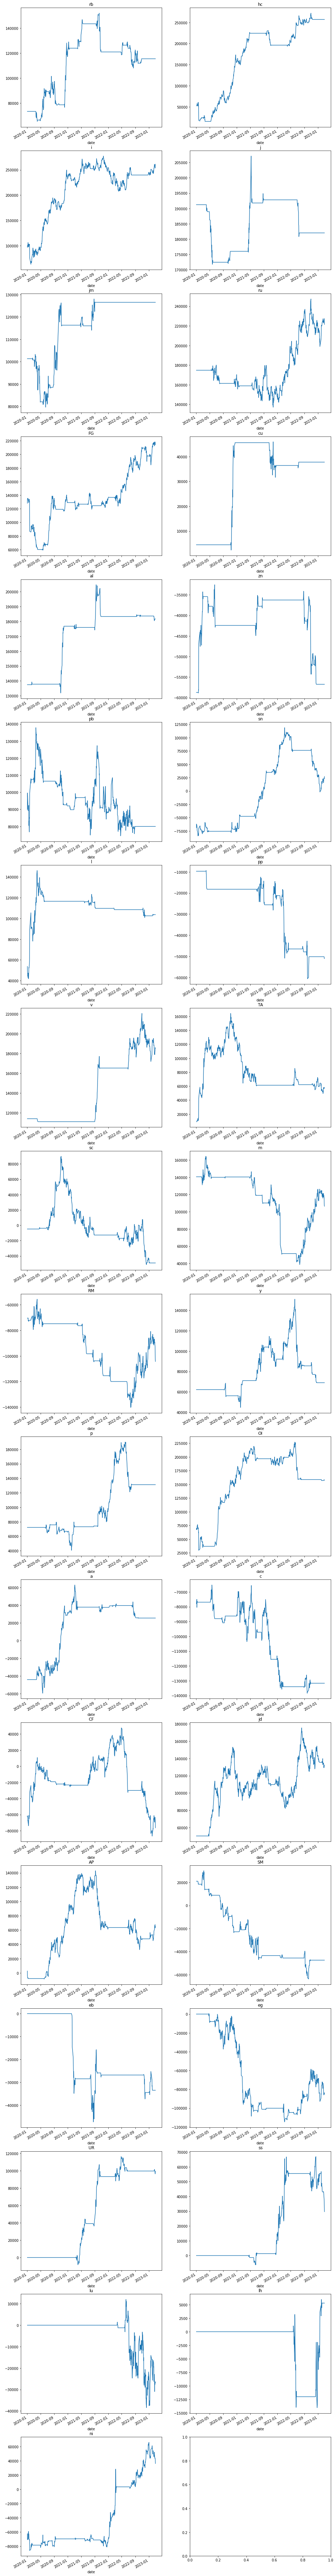

In [15]:
#plot_stats = scen_stats[0]
plot_stats = pnl_stats
asset_pnl = plot_stats['asset_cumpnl']
asset_stats = plot_stats['asset_sharpe_stats']
plot_start = pd.to_datetime('2020-01-01')

rows = math.ceil(len(product_list)/2)
fig, ax = plt.subplots(rows, 2, figsize=(16, 150))

for i, col in enumerate(asset_pnl.columns):
    row_id = i//2
    col_id = i % 2
    asset_pnl[col][plot_start:].plot(ax = ax[row_id, col_id], title = col)

print(asset_stats[product_list])
    

# smoothed pnl and lagged pnl

smoothed PNL
                  1         5         10        20        30        60  \
sharpe     0.175127 -0.028105 -0.098967 -0.166326 -0.197475 -0.201858   
sharpe_fh -0.644267 -0.688182 -0.705753 -0.724333 -0.725929 -0.688596   
sharpe_sh  1.757540  1.379782  1.254718  1.117915  1.025846  0.890852   

                 75        80  
sharpe    -0.185417 -0.178971  
sharpe_fh -0.665222 -0.657703  
sharpe_sh  0.858847  0.850731  


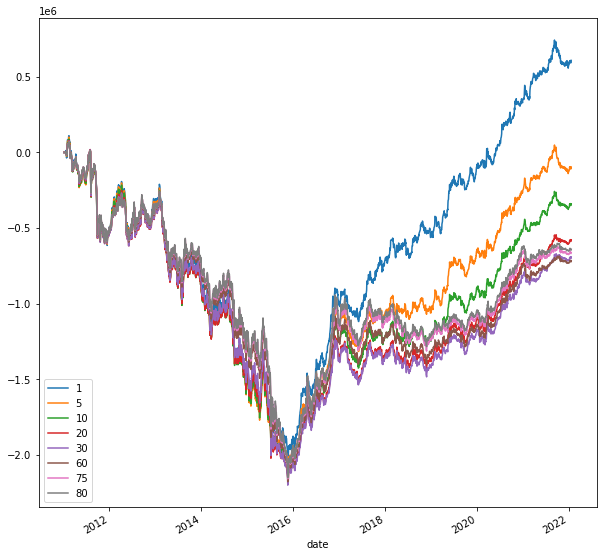

lagged PNL
                  1         5         10        20        30        60  \
sharpe     0.151961 -0.096850 -0.112085 -0.323440 -0.037762 -0.189401   
sharpe_fh -0.621991 -0.667313 -0.737889 -0.746321 -0.664814 -0.681529   
sharpe_sh  1.562776  0.929591  1.030327  0.397362  1.089161  0.661962   

                 75        80  
sharpe    -0.321416 -0.299983  
sharpe_fh -0.670788 -0.611414  
sharpe_sh  0.313514  0.270256  


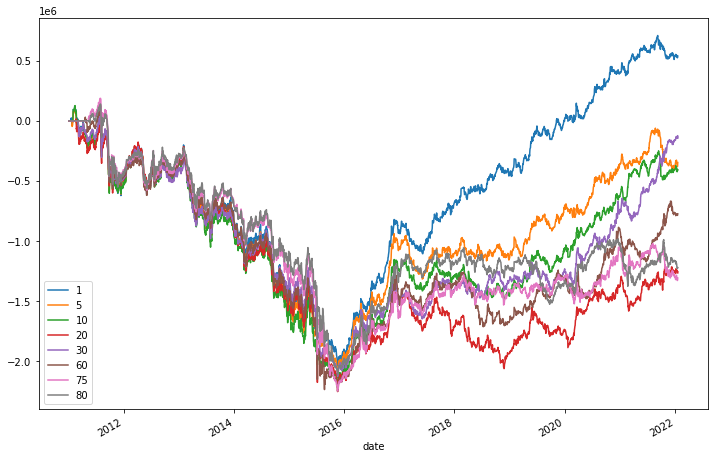

In [16]:

bt_metrics = scen_metrics[2]
smoothed = bt_metrics.smoothed_pnl(smooth_hls=[1, 5, 10, 20, 30, 60, 75, 80])
smoothed['cumpnl'].plot(figsize=(10,10))
print('smoothed PNL\n', smoothed['sharpe'])
plt.show()

lagged = bt_metrics.lagged_pnl(lags=[1, 5, 10, 20, 30, 60, 75, 80])
lagged['cumpnl'].plot()
print('lagged PNL\n', lagged['sharpe'])
plt.show()

# scenario PNL and correlations

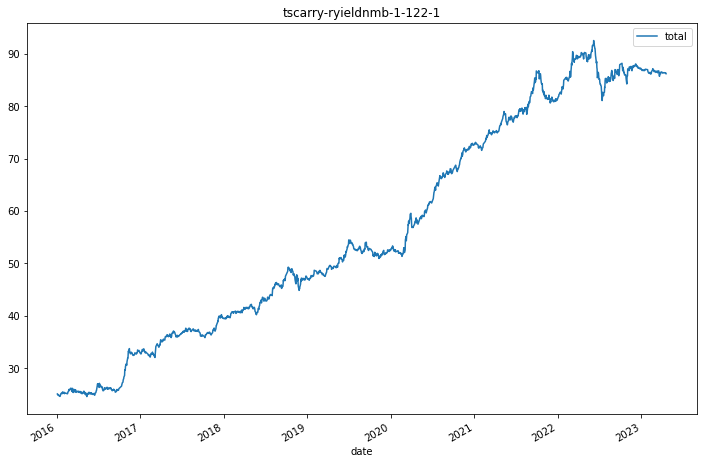

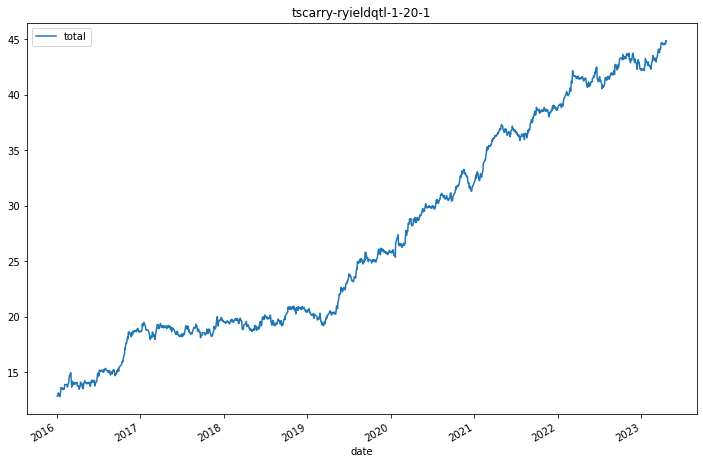

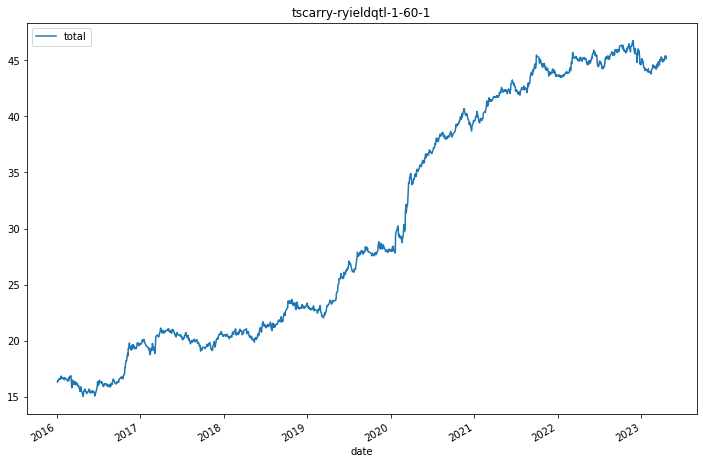

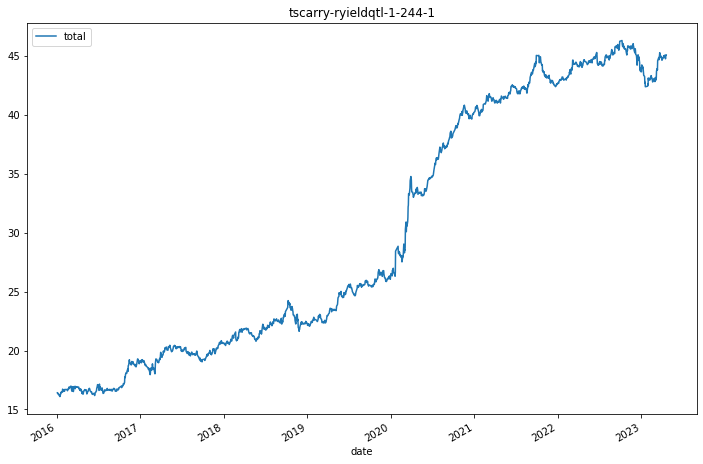

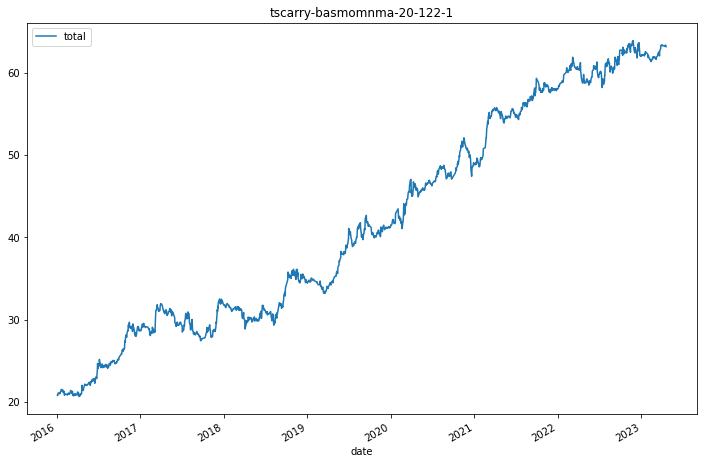

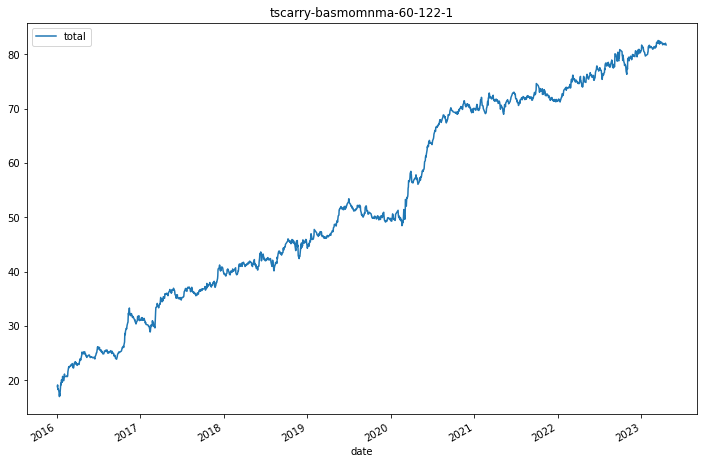

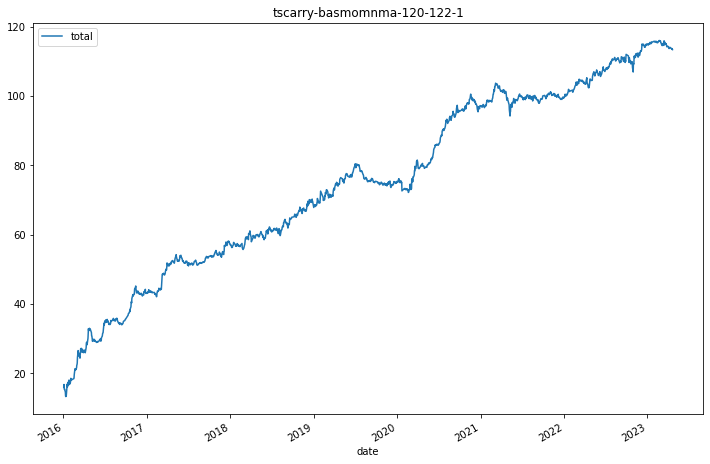

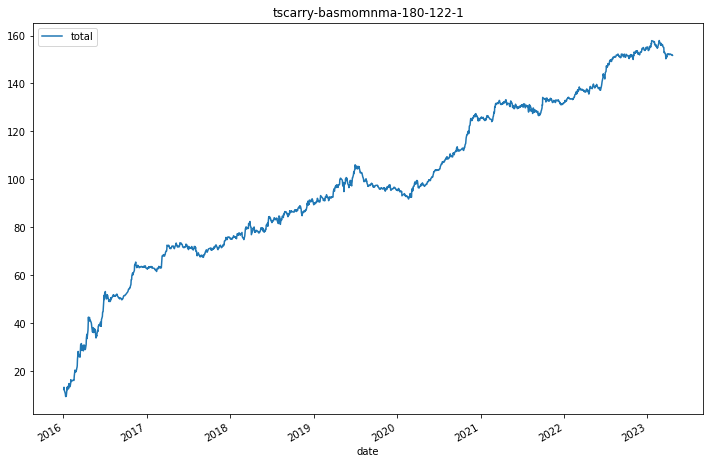

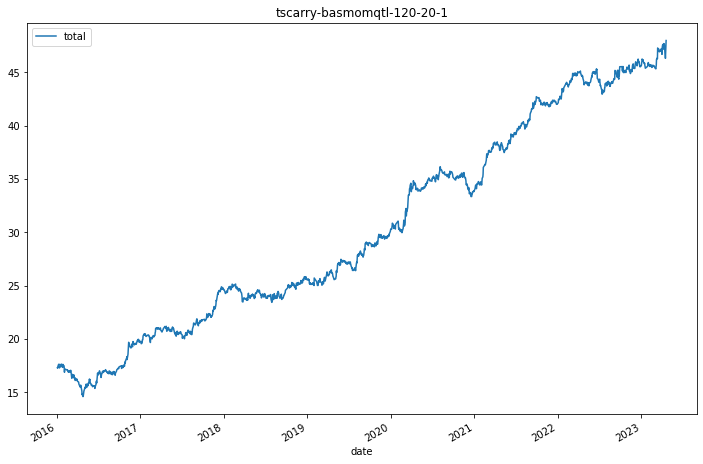

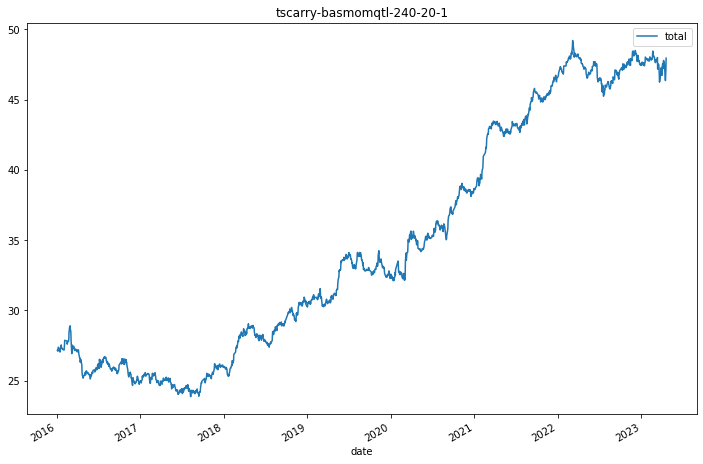

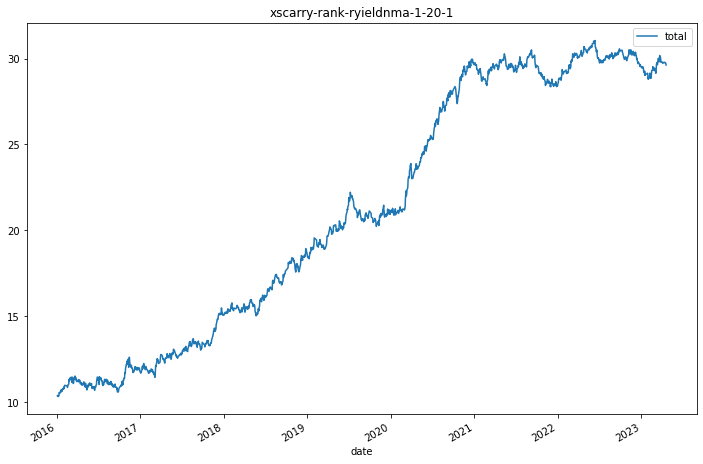

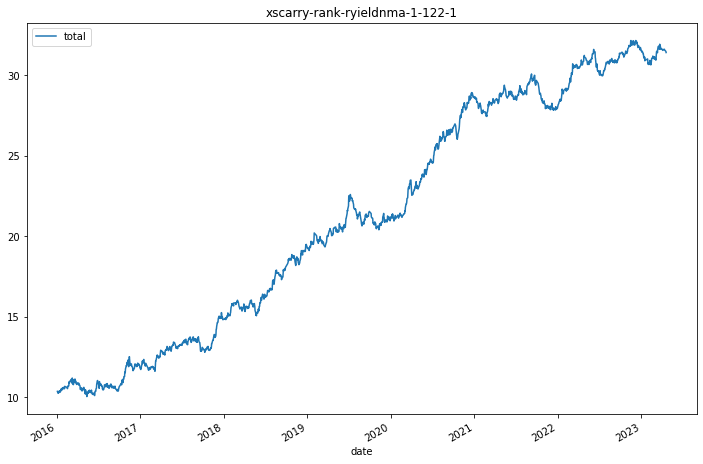

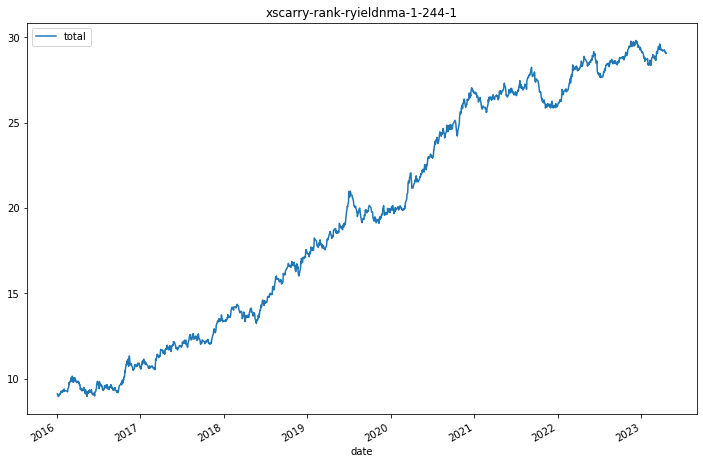

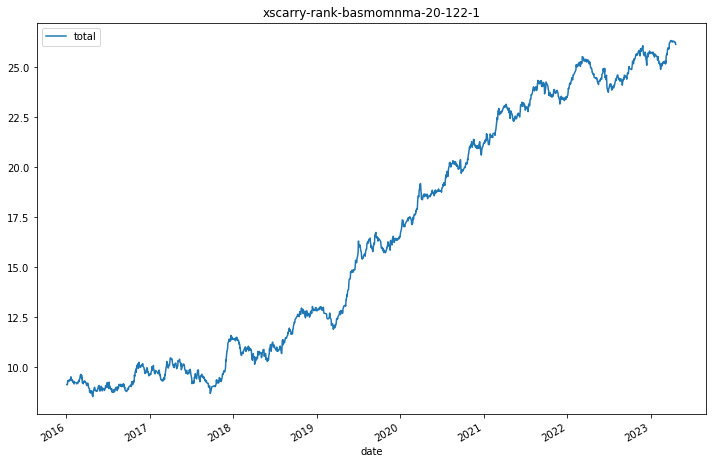

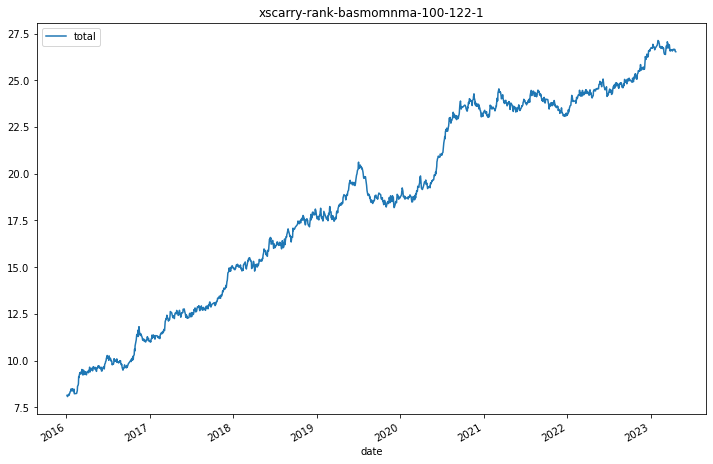

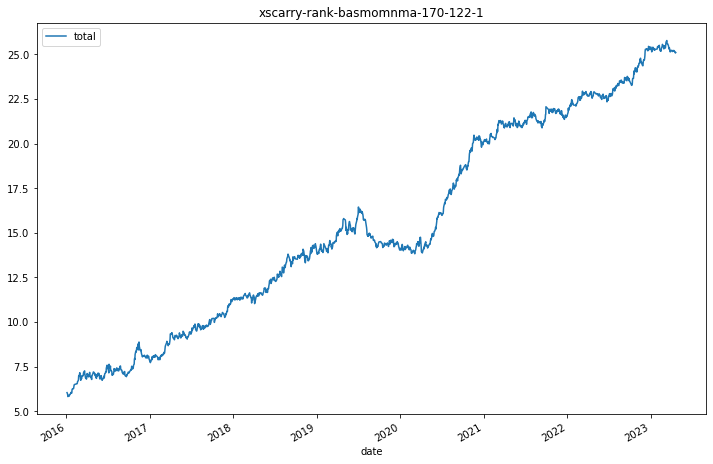

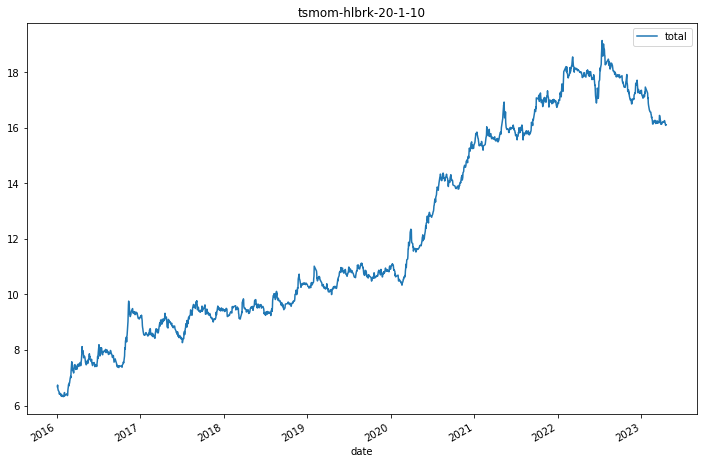

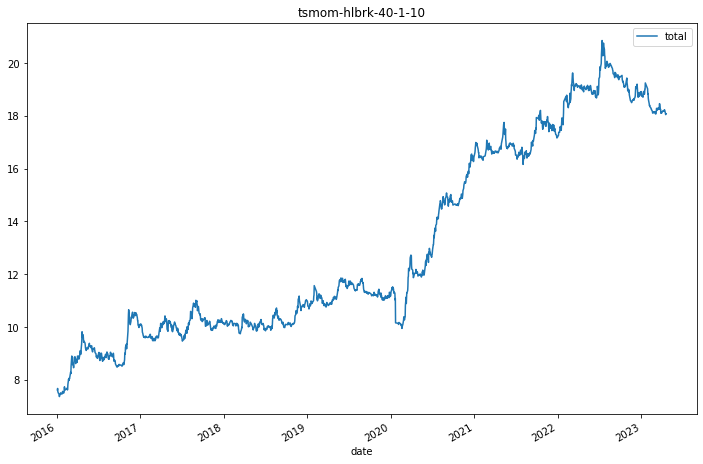

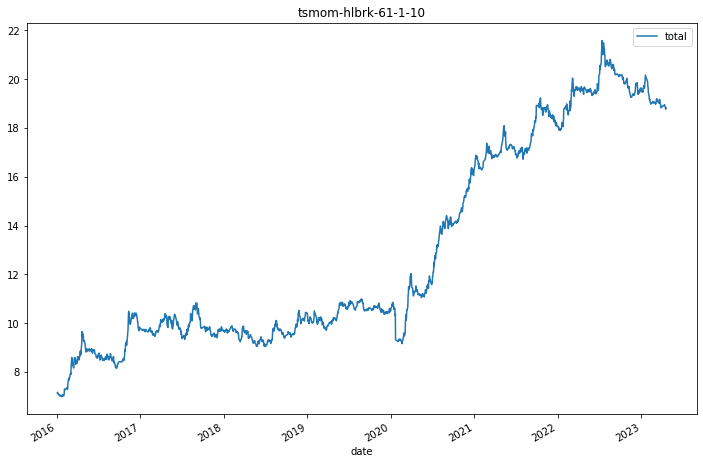

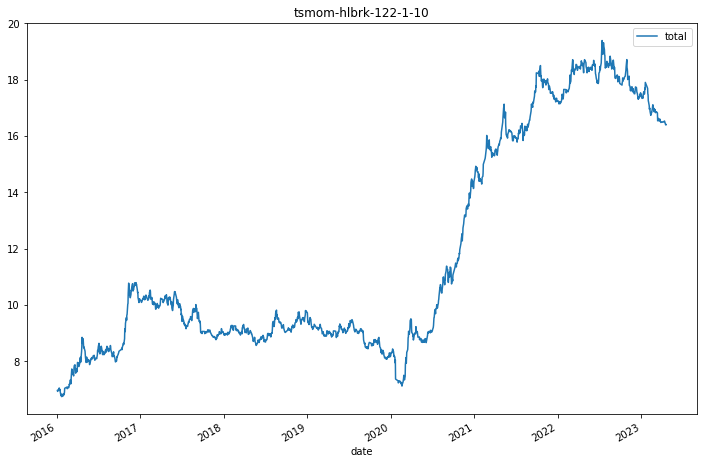

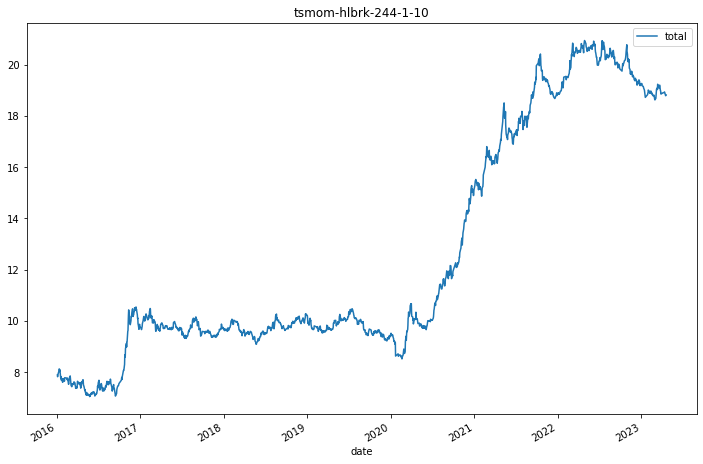

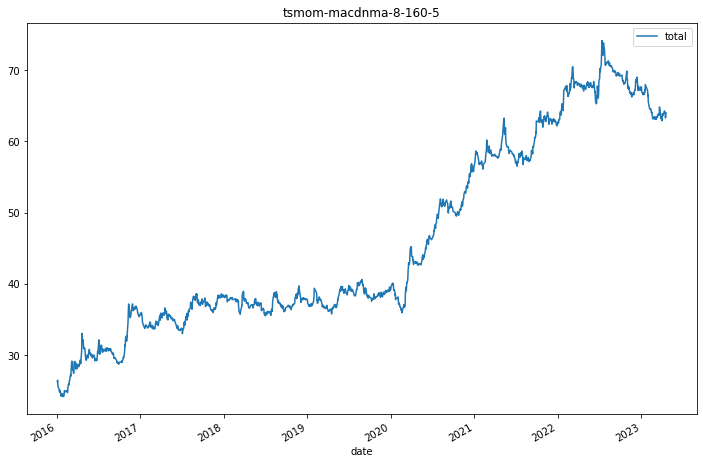

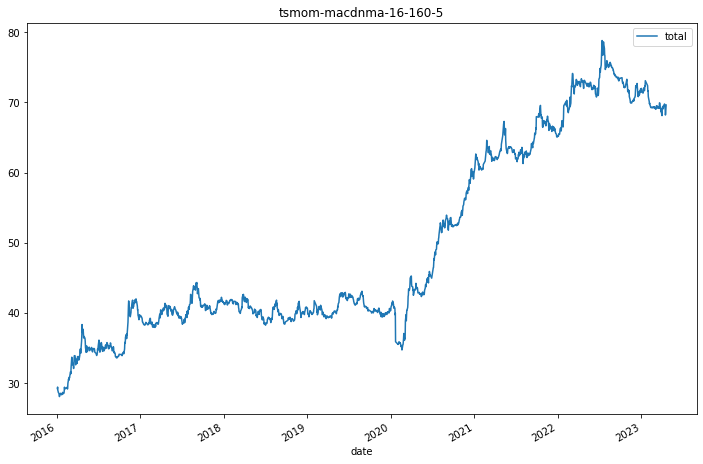

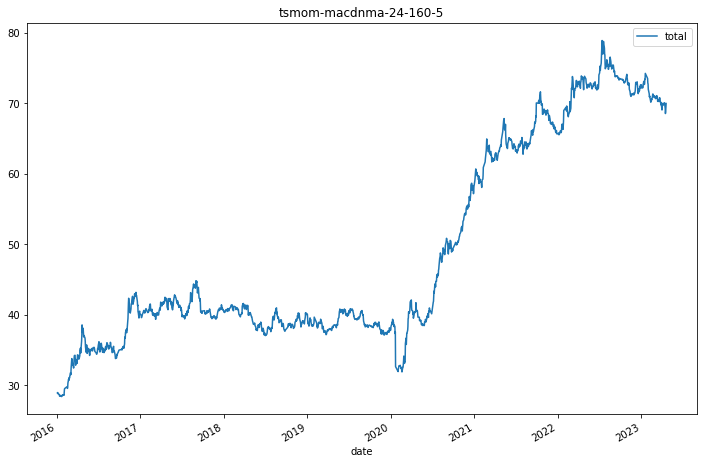

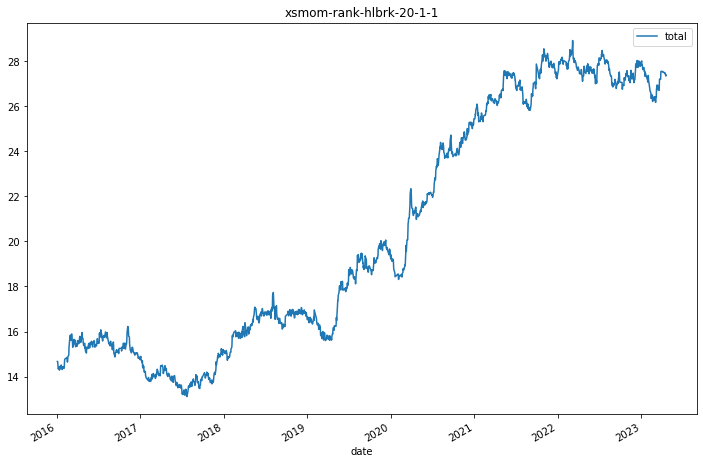

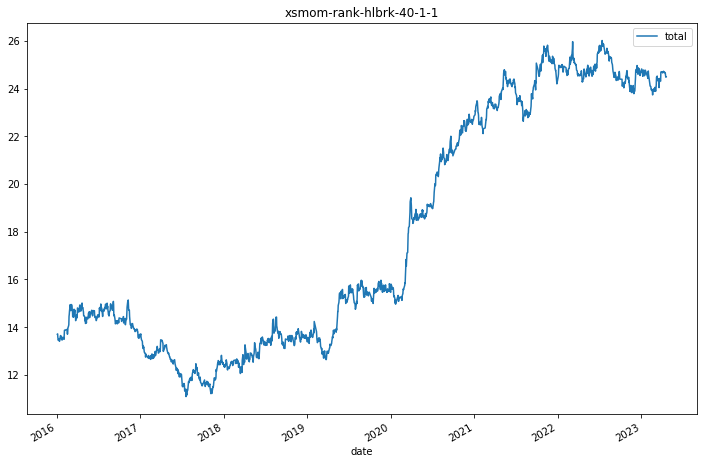

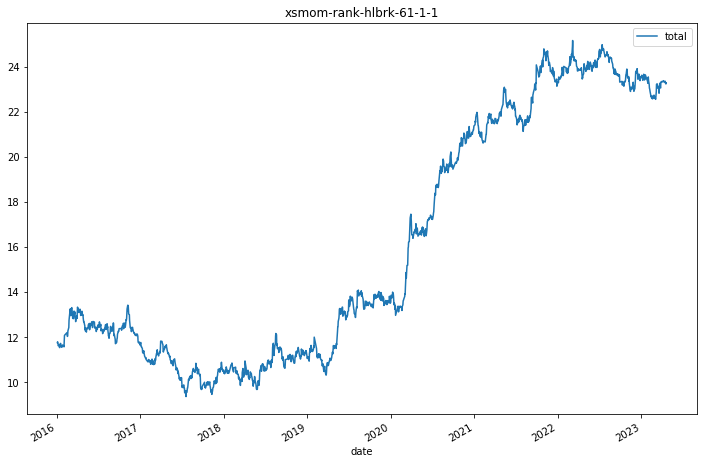

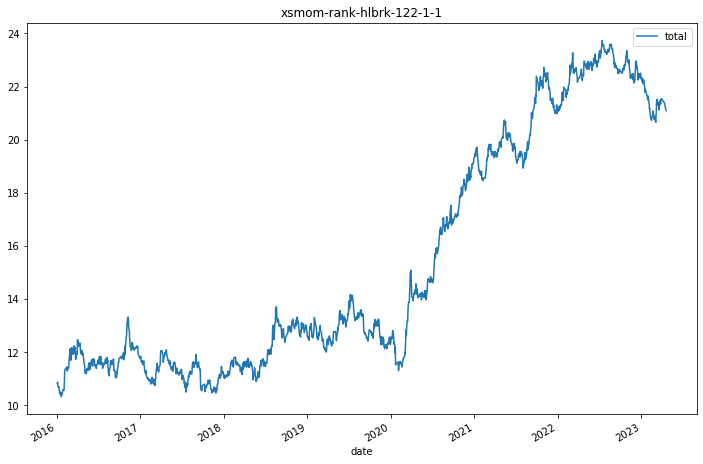

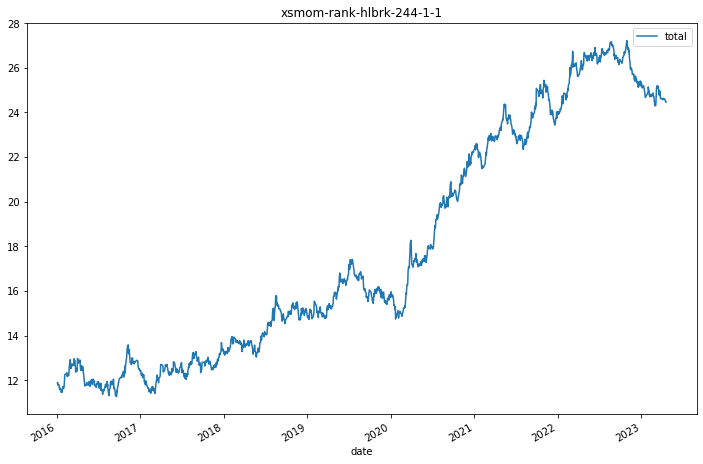

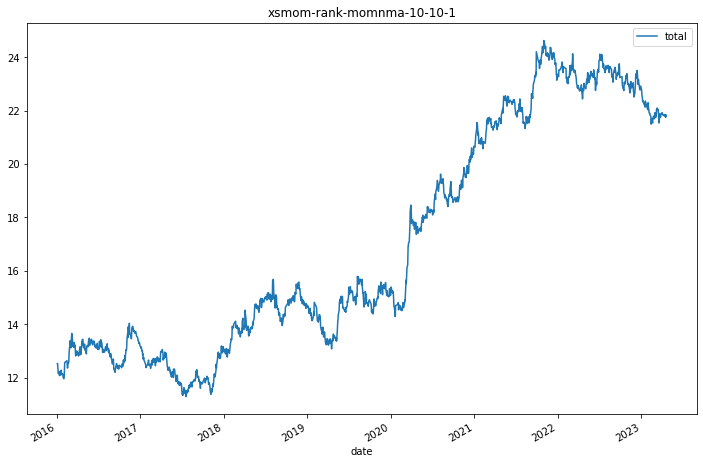

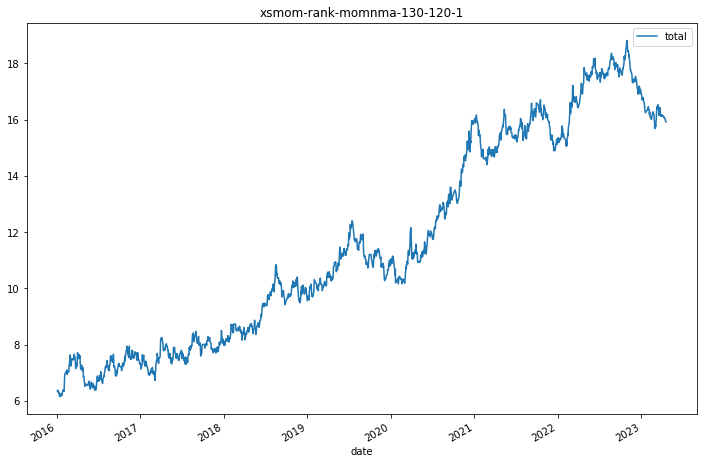

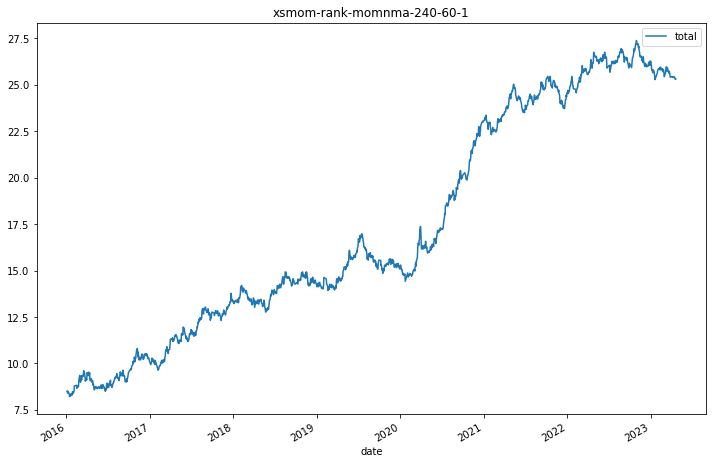

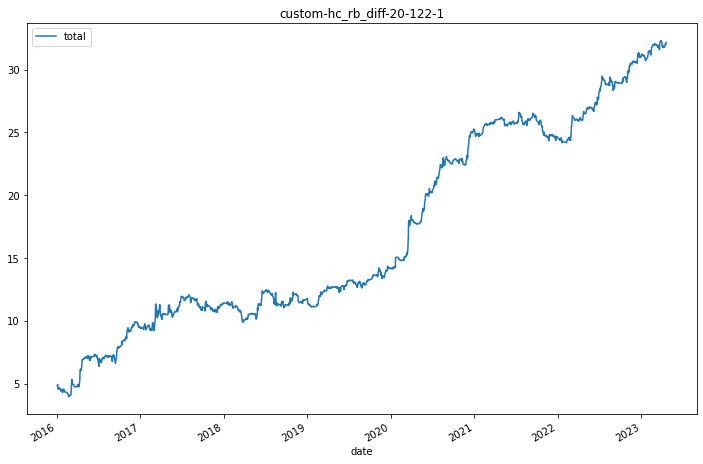

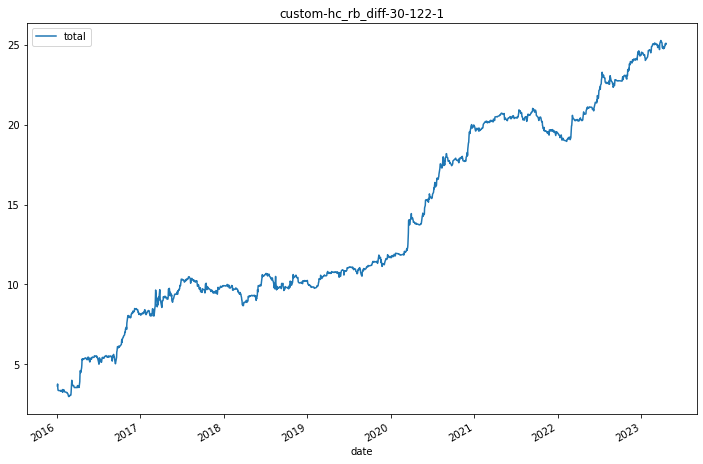

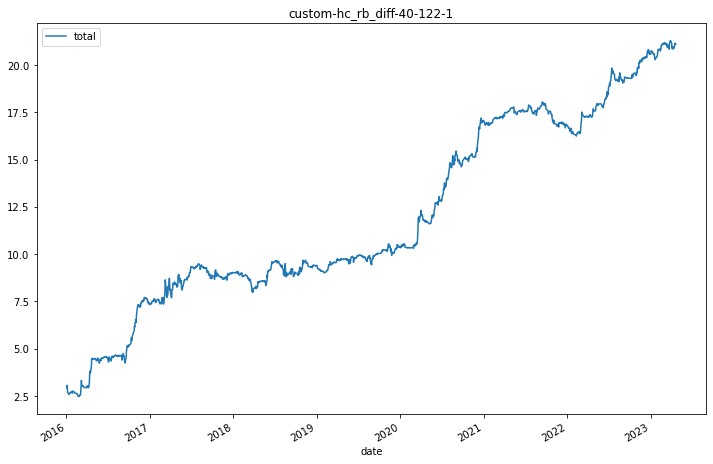

In [19]:
scen_start = pd.to_datetime('2016-01-01')
df_list = []
hot_key = 'hot_test'
for scen_name, scen_stat in zip(scen_names[hot_key], scen_stats[hot_key]):
    scen_stat['portfolio_cumpnl'][scen_start:].plot(title=scen_name)
    plt.show()
    ts = scen_stat['portfolio_pnl'][scen_start:]
    ts.name = scen_name
    df_list.append(ts)
dpnl_df = pd.concat(df_list, axis=1, join='outer').fillna(0)
dpnl_df.columns = scen_names[hot_key]
scen_corr = dpnl_df.corr()

# print(scen_corr)
scen_corr.to_csv(file_folder + "port_corr.csv")

# some test for backtest code

In [ ]:
input_args = run_args
product_list = input_args['product_list']
vol_win = input_args['std_win']
total_risk = input_args.get('total_risk', 5000000.0)
shift_mode = input_args.get('shift_mode', 1)
asset_scaling = input_args.get('asset_scaling', False)
exec_mode = input_args.get('exec_mode', 'open')
signal_df = generate_signal(df, input_args)

start_date = input_args.get('start_date', None)
end_date = input_args.get('end_date', None)

if start_date:
    signal_df = signal_df[signal_df.index >= pd.to_datetime(start_date)]
if end_date:
    signal_df = signal_df[signal_df.index <= pd.to_datetime(end_date)]

if shift_mode == 1:
    vol_df = get_asset_vols(df, product_list, vol_win=vol_win, vol_type='atr')
elif shift_mode == 2:
    vol_df = get_asset_vols(df, product_list, vol_win=vol_win, vol_type='lret')
else:
    vol_df = get_asset_vols(df, product_list, vol_win=vol_win, vol_type='close')


In [ ]:
holding = generate_holding_from_signal(signal_df, vol_df,
                                       risk_scaling=total_risk,
                                       asset_scaling=asset_scaling)
holding

In [ ]:
mpl.rcParams['figure.figsize'] = (8, 6)

# batch run backtest for multiple factors

In [ ]:
from bktest.backtest_grid_search import *

In [ ]:
df, error_list = load_hist_data(
    start_date=datetime.date(2010,1,1),
    end_date=datetime.date(2022,1,20),
    sim_markets=commod_all_mkts,
    freq='d'
)

if len(error_list) > 0:
    print(error_list)
print(df.tail(10))

In [11]:
start_d = datetime.date(2012,1,1)
end_d = datetime.date(2020,1,1)
product_list = ['rb', 'hc', 'i', 'j', 'jm', 'ru', 'FG', 'cu', 'al', 'zn', 'pb', 'sn', \
                'l', 'pp', 'v', 'TA', 'sc', 'm', 'RM', 'y', 'p', 'OI', 'a', 'c', 'CF', 'jd', \
                'AP', 'SM', 'eb', 'eg', 'UR', 'ss', 'lu', 'lh', 'ni',]

sim_group = [
    ('xscarry-rank', 'basmomema'), ('xscarry-rank_cutoff', 'basmomema'), ('xscarry-demedian', 'basmomema'),
    ('xscarry-rank', 'basmomqtl'), ('xscarry-rank_cutoff', 'basmomqtl'), ('xscarry-demedian', 'basmomqtl'),
]

index_list = range(10, 260, 10)
column_list = [10, 20, 40, 61, 80, 100, 122, 244]

bt_metric_dict = {}
pnl_stats_dict = {}
for sim_type, signal_name in sim_group:
    print(f"processing {sim_type} - {signal_name}")
    metric_dict, stat_dict = run_grid_btest(df, start_d, end_d, 
                                            sim_type, signal_name,
                                            index_list=index_list,
                                            column_list=column_list,
                                            product_list=product_list,
                                            pnl_tenors=True,
                                            exp_mean=False)
    bt_metric_dict[(sim_type, signal_name)] = metric_dict
    pnl_stats_dict[(sim_type, signal_name)] = stat_dict


processing xscarry-rank - basmomema
sharpe
        sharpe                                                              \
X         10        20        30        40        50        60        70    
Y                                                                           
10   1.614742  1.277921  1.149956  1.163646  1.306326  1.453083  1.396669   
20   1.569257  1.258853  1.122001  1.052935  1.220969  1.373404  1.471871   
40   1.512389  1.172369  1.114697  1.224178  1.415782  1.588075  1.622037   
61   1.416166  1.267703  1.275787  1.443834  1.570414  1.649171  1.782928   
80   1.510609  1.444942  1.441870  1.580338  1.649718  1.781360  1.666051   
100  1.618194  1.585641  1.606040  1.631402  1.706475  1.831097  1.722611   
122  1.679263  1.672687  1.633591  1.648201  1.732921  1.685257  1.688770   
244  1.930602  1.721691  1.578035  1.583048  1.622187  1.587168  1.406779   

                                                                           \
X         80        90        1

sharpe
        sharpe                                                              \
X         10        20        30        40        50        60        70    
Y                                                                           
10   0.961644  0.850101  0.542298  0.564878  0.907803  1.176584  1.080917   
20   0.997791  0.821020  0.784525  0.680190  0.859258  0.873404  0.975884   
40   1.053649  0.718902  0.772178  0.606393  0.844922  0.904332  1.089073   
61   0.877748  0.814401  0.766541  0.745674  1.116072  1.053328  1.345649   
80   0.904226  0.611450  0.831292  1.050503  1.070957  1.328911  1.346268   
100  0.963891  0.668234  0.884209  1.131260  1.289680  1.424650  1.409480   
122  0.973558  1.019541  0.986336  1.240259  1.272369  1.397335  1.427413   
244  1.414127  1.254074  1.192335  1.239075  1.403859  1.275618  1.248176   

                                                                           \
X         80        90        100       110       120       130    

sharpe
        sharpe                                                              \
X         10        20        30        40        50        60        70    
Y                                                                           
10   0.955090  0.664579  0.615038  0.854317  0.916838  1.037633  1.267797   
20   0.861529  0.613638  0.559733  0.785545  0.956045  1.043963  1.302413   
40   0.793962  0.586456  0.723202  0.947183  1.104372  1.276484  1.241261   
61   0.854896  0.833086  0.975621  1.128429  1.292592  1.273970  1.249311   
80   1.031926  0.957482  1.108392  1.313092  1.311820  1.356991  1.289012   
100  1.183474  1.096556  1.283198  1.367567  1.451183  1.429789  1.322831   
122  1.283500  1.331795  1.402842  1.473978  1.496667  1.450648  1.378725   
244  1.663999  1.570343  1.551242  1.510486  1.419748  1.335248  1.288256   

                                                                           \
X         80        90        100       110       120       130    

sharpe
        sharpe                                                              \
X         10        20        30        40        50        60        70    
Y                                                                           
10   0.026445  0.195808  0.091119  0.020574  0.077504 -0.033215  0.063308   
20   0.069981  0.179781  0.162675  0.044837  0.030897  0.101355  0.020628   
40   0.112784  0.171735 -0.017084  0.021616 -0.024544 -0.048392 -0.059657   
61   0.053544  0.134753 -0.046590 -0.033134  0.004893 -0.035727  0.035108   
80   0.087509  0.112451 -0.069410 -0.008311  0.020059  0.028902  0.014610   
100  0.103581  0.133395 -0.036067 -0.024282  0.032880  0.046212  0.006600   
122  0.146267  0.171257  0.002122  0.002107 -0.004599 -0.012242 -0.012186   
244  0.113145  0.133845 -0.009819  0.055215  0.027588  0.033282  0.038403   

                                                                           \
X         80        90        100       110       120       130    

sharpe
        sharpe                                                              \
X         10        20        30        40        50        60        70    
Y                                                                           
10   0.303093  0.456177  0.544671  0.261198  0.240850  0.329509  0.392687   
20   0.464464  0.468610  0.509708  0.468446  0.282770  0.311792  0.507697   
40   0.435524  0.272292  0.257865  0.402108  0.053007  0.177594  0.247851   
61   0.327841  0.166931  0.234505  0.442540  0.291625  0.129500  0.428201   
80   0.181661  0.395176  0.313531  0.406295  0.315727  0.211651  0.393439   
100  0.276333  0.474959  0.298078  0.323192  0.264907  0.183911  0.305509   
122  0.258942  0.490874  0.402562  0.377740  0.388726  0.105426  0.251691   
244  0.254386  0.536683  0.435931  0.443499  0.415694  0.417607  0.473916   

                                                                           \
X         80        90        100       110       120       130    

sharpe
        sharpe                                                              \
X         10        20        30        40        50        60        70    
Y                                                                           
10   0.080555  0.394343  0.188490  0.055662  0.159537 -0.056100  0.251503   
20   0.292385  0.368419  0.261938  0.121742  0.037321  0.193153  0.281223   
40   0.277419  0.269395  0.151222  0.027420  0.051603  0.147162  0.142273   
61   0.309125  0.354381  0.228711  0.038752  0.189528  0.195760  0.166875   
80   0.313721  0.349788  0.140687  0.088655  0.214775  0.176740  0.100634   
100  0.324264  0.344603  0.177097  0.150082  0.213231  0.191651  0.145774   
122  0.397868  0.497812  0.201037  0.122512  0.274170  0.111650  0.133741   
244  0.386891  0.517558  0.122946  0.234125  0.261104  0.187221  0.198922   

                                                                           \
X         80        90        100       110       120       130    

# Batch run sample code 2

In [72]:
from bktest.backtest_grid_search import *

xdf, error_list = load_hist_data(
    start_date=datetime.date(2010, 1, 1),
    end_date=datetime.date(2020, 1, 1),
    sim_markets=all_markets,
    freq='d'
)


group_keys=['all']

sim_group=[
    ('xsmom-demedian', 'momnma'),
    ('xsmom-demedian', 'macdnma'),
    # ('xscarry-rank', 'ryieldnma'),
    # ('xscarry-rank_cutoff', 'ryieldnma'),
    # ('xscarry-rank', 'basmomnma'),
    # ('xscarry-rank_cutoff', 'basmomnma'),
    # ('xscarry-rank', 'ryieldsma'),
    # ('xscarry-rank_cutoff', 'ryieldsma'),
]

bt_metric_dict, pnl_stats_dict = run_xs_product(xdf, group_keys, sim_group)


processing product = all for xsmom-demedian - momnma
processing product = all for xsmom-demedian - macdnma
